In [1]:
# from joblib import Parallel, delayed

import numpy as np

import sympy
import scipy
import scipy.optimize
import scipy.special
import scipy.misc
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy import interp

from ProbabilityTheory import *


EPS = 1e-9

from tqdm import tqdm as tqdm




In [18]:
import matplotlib

import matplotlib.pylab as plt
%matplotlib inline

titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
# matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['figure.figsize'] = (16, 10)

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

# # matplotlib.rc('font', **{'family':'serif'})
# matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', unicode=True)
# matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
# matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
# matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

## Classes for densities  etc

In [9]:
uniform_cdf = UniformCDF([0, 1])
uniform_pdf = CDF_to_PDF(uniform_cdf)
uniform_order_3_10 = k_statistics_PDF(3, 10,  uniform_cdf)
uniform_order_10_10 = k_statistics_PDF(10, 10,  uniform_cdf)

In [10]:
uniform_order_3_10_cdf = k_statistics_CDF(3, 10, uniform_cdf)

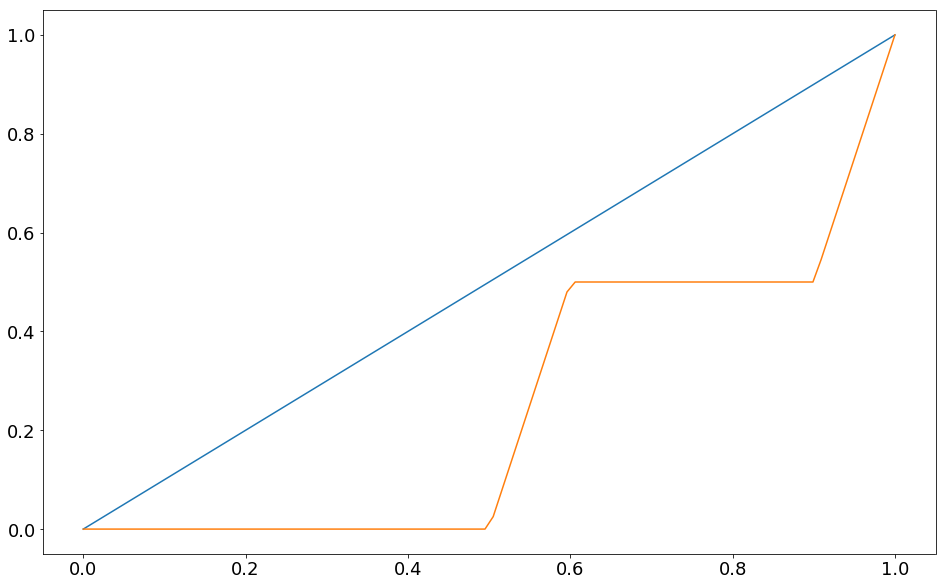

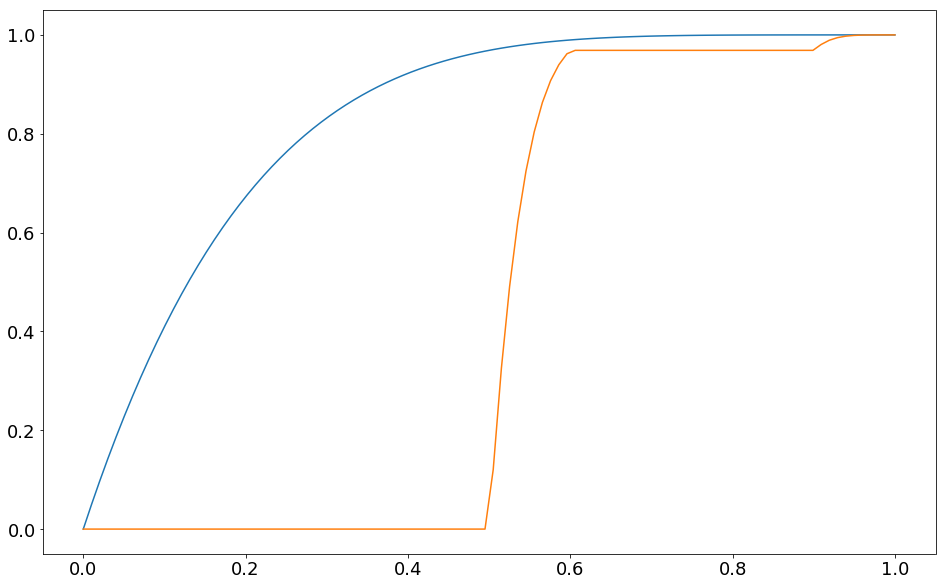

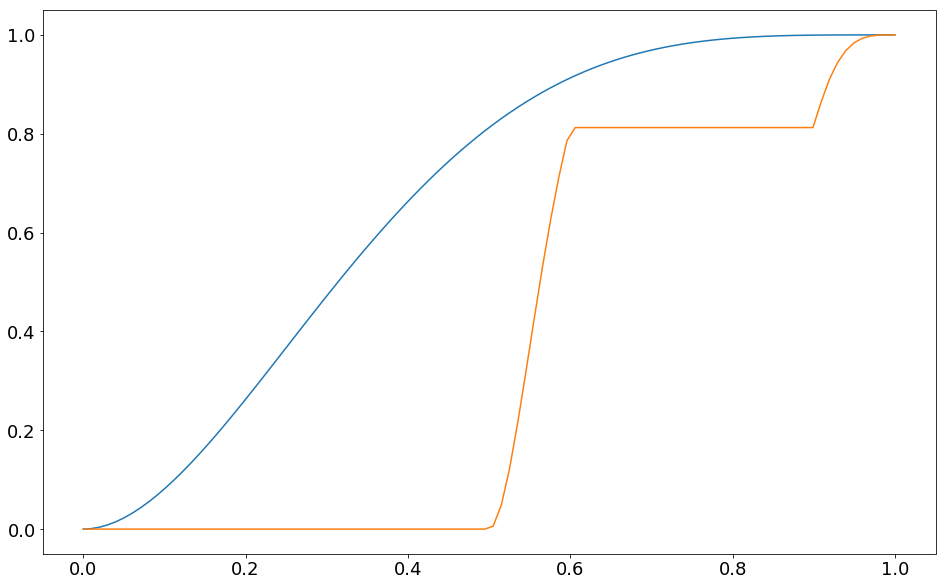

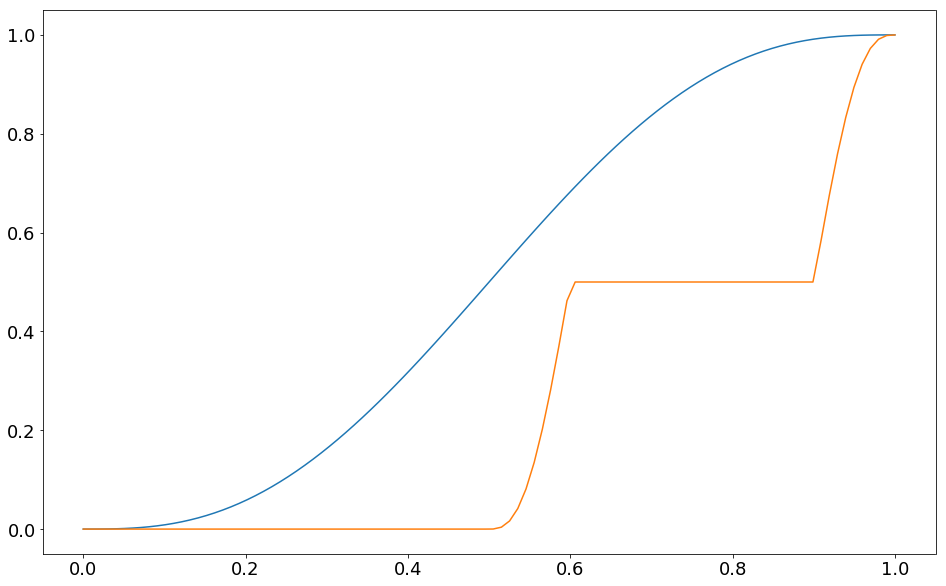

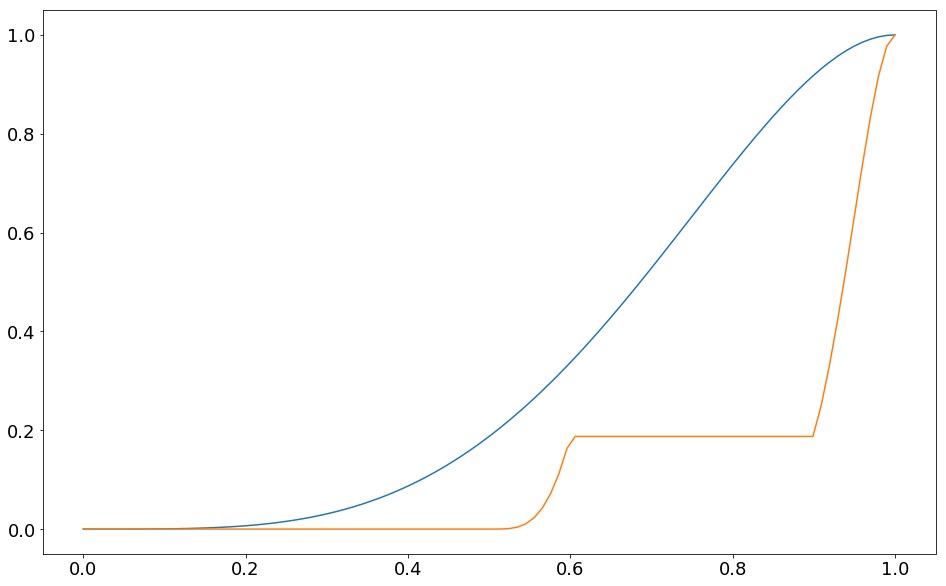

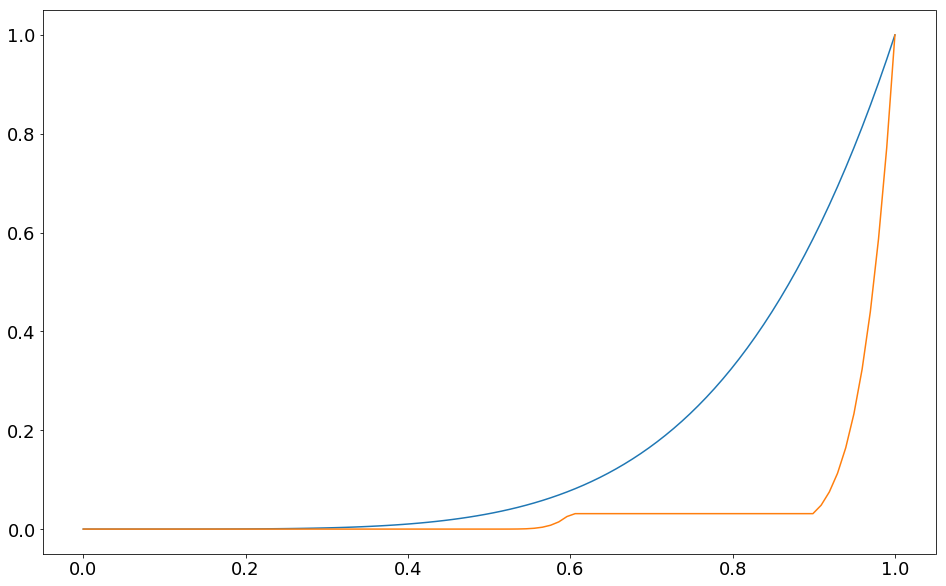

In [11]:
def two_deltas(x, a=0.5, b=0.9):
    step = 0.1
    
    if x < a:
        return 0
    if x < a + step:
        return (x - a) * 0.5 / step
    if x < b:
        return 0.5
    if x < b + step:
        return 0.5 + (x - b) * 0.5 / step
    return 1

x =  np.linspace(0, 1, 100)
n = 5

CDF_1 = UniformCDF([0, 1])
CDF_2 = CDF(two_deltas, bounds=[0, 1.5])

plt.plot(x, CDF_1(x))
plt.plot(x, CDF_2(x))
plt.show()


for i in range(1, n + 1):
    plt.plot(x, k_statistics_CDF(i, n, CDF_1)(x), label="CDF1 " + str(i))
    plt.plot(x, k_statistics_CDF(i, n, CDF_2)(x), label="CDF2 " + str(i))
#     plt.plot(x, k_statistics_PDF(i, n, CDF_1)(x), label="PDF1 " + str(i))
#     plt.plot(x, k_statistics_PDF(i, n, CDF_2)(x), label="PDF2 " + str(i))
    plt.show()

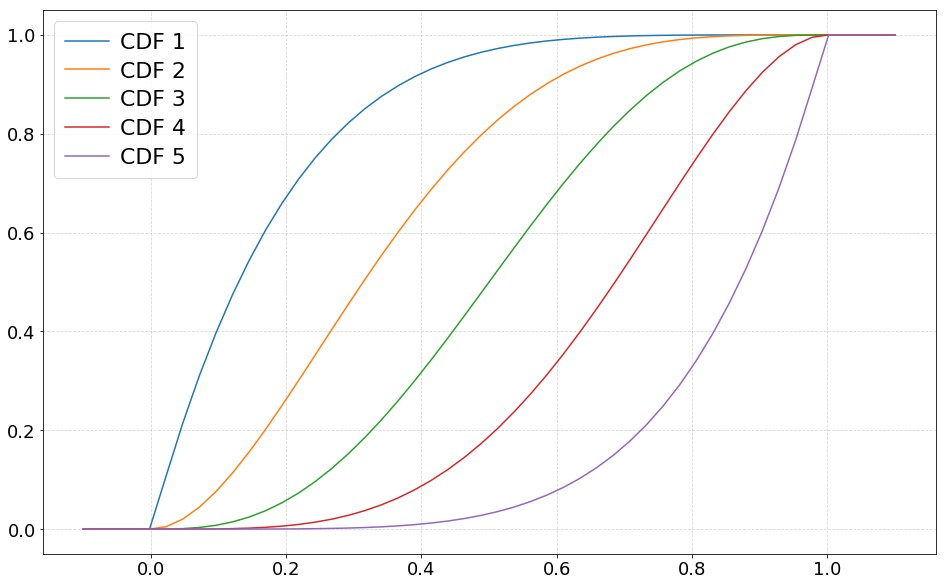

In [12]:
x = np.linspace(-0.1, 1.1)
n = 5

for i in range(1, n + 1):
    plt.plot(x, k_statistics_CDF(i, n, uniform_cdf)(x), label="CDF " + str(i))
#     plt.plot(x, k_statistics_PDF(i, n, uniform_cdf)(x), label="PDF " + str(i))

# plt.plot(x, uniform_order_3_10(x), label="PDF")
# plt.plot(x, int_x(x), label="PDF")
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

### Sanity checks

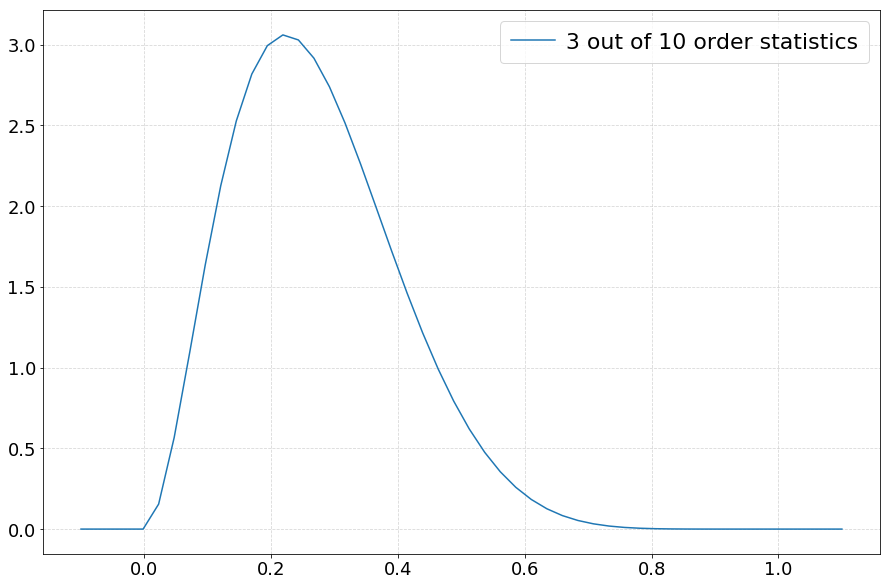

In [13]:
plt.figure(figsize=(15, 10))
# plt.plot(x, uniform_cdf(x), label="CDF")
# plt.plot(x, new(x), label="PDF")
plt.plot(x, uniform_order_3_10(x), label="3 out of 10 order statistics")
# plt.plot(x, uniform_order_10_10(x), label="10 out of 10 order statistics")
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

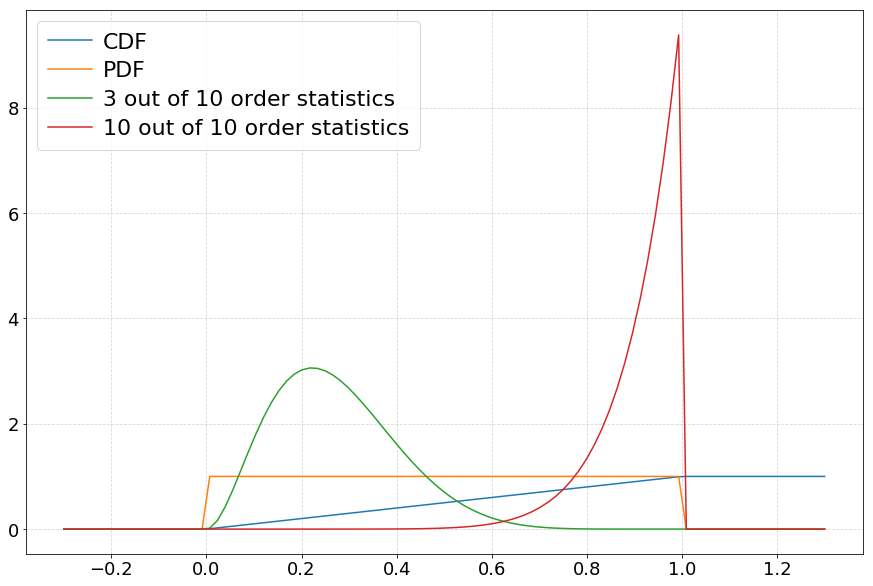

In [14]:
uniform_cdf = UniformCDF([0, 1])
uniform_pdf = CDF_to_PDF(uniform_cdf)
uniform_order_3_10 = k_statistics_PDF(3, 10,  uniform_cdf)
uniform_order_10_10 = k_statistics_PDF(10, 10,  uniform_cdf)

x = np.linspace(-0.3, 1.3, 100)

plt.figure(figsize=(15, 10))
plt.plot(x, uniform_cdf(x), label="CDF")
plt.plot(x, uniform_pdf(x), label="PDF")
plt.plot(x, uniform_order_3_10(x), label="3 out of 10 order statistics")
plt.plot(x, uniform_order_10_10(x), label="10 out of 10 order statistics")
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

In [15]:
assert(integrate.quad(lambda x : x * uniform_order_3_10(x), 0, 10)[0] - 3/11 < 0.0000001)

## Solution for our problem

### PriceOverDerivative calculation

In [2]:
class PriceOverDerivative:
    def __init__(self,  n, F = UniformCDF()):
        self.F = F
        self.n = n
    
    def __call__(self, x):
        x = np.asarray(x)
        return (1 - np.power(self.F(x), self.n)) / x
    
    def solve(self, rhs, x_0=0.3):
        solution = scipy.optimize.newton(lambda  x: self.__call__(x) - rhs, x_0)
        
        if self.__call__(solution) - rhs > 0.001:
            raise Exception("solve failed")
        
        return solution  

### Calculation of sum of integrals (left hand side)

In [3]:
def GetValuesForSameSearhCosts(n, G=None, f=None):
    if not G:
        G = MakeUniformCDF([0, 0.1])
    
    g = CDF_to_PDF(G)
        
    if not f:
        f = PDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])
    
    values = np.array([integrate.quad(lambda x : Power(f, i)(x) * g(x), 0, 0.5) for i in range(n)])
    
    errors = values[:, 1]
    values = values[:, 0]
    return values, errors

def GetValuesForDifferentSearhCosts(n, G=None, f=None):
    if not G:
        G = UniformCDF([0, 0.1])
    
    g = CDF_to_PDF(G)
    
    if not f:
        f = PDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])

    values = np.zeros((n, 2))
    
    for i in range(n):
        g_current = k_statistics_PDF(i + 1, n, G)
        values[i] = integrate.quad(lambda x : Power(f, i)(x) * g_current(x), 0, 0.5)
    
    errors = values[:, 1]
    values = values[:, 0]
    
    return values, errors

# x, _ = GetValuesForSameSearhCosts(7, G=MakeUniformCDF([0, 0.02]))
# x, _ = GetValuesForDifferentSearhCosts(7)
# x.sum()

### Merge everything here

In [4]:
def solution_for_same_and_different_search_costs(n, G=None, verbose=False):
    if n < 1:
        print(n)
        raise Exception("choose n > 1")
        
    POD = PriceOverDerivative(n)
    
    f = PDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])    

    if not G:
        G = UniformCDF([0, 0.1])
    
    rhs, errors = GetValuesForSameSearhCosts(n, G=G, f=f)
    rhs_sum = rhs.sum()
    error = errors.sum()
    same_prices = POD.solve(rhs_sum, 0.3)

    if verbose:
        print("Same search costs case:")
        print("RHS =",  rhs_sum)
        print(same_prices)
    #     print(POD.solve(rhs_sum - 5 * error, 0.4), POD.solve(rhs_sum + 5 * error, 0.4))
        print()

    rhs_2, errors = GetValuesForDifferentSearhCosts(n, G=G, f=f)
    rhs_2_sum = rhs_2.sum()
    error = errors.sum()
    different_prices = POD.solve(rhs_2_sum, 0.3)
    
    if verbose:
        print("Different search costs case:")
        print("RHS =",  rhs_2_sum)
        print(different_prices)
    #     print(POD.solve(rhs_2_sum - 5 * error, 0.4), POD.solve(rhs_2_sum + 5 * error, 0.4))

    return same_prices, different_prices
    
#     return rhs, rhs_2

def vectors_for_same_search_costs(n, G=None):
    if n < 1:
        print(n)
        raise Exception("choose n > 1")
        
    f = PDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])    

    if not G:
        G = UniformCDF([0, 0.1])
    
    rhs_2, errors = GetValuesForSameSearhCosts(n, G=G, f=f)
    
    return rhs_2

def vectors_for_different_search_costs(n, G=None):
    if n < 1:
        print(n)
        raise Exception("choose n > 1")
        
    f = PDF(lambda x: 1 - np.sqrt(2 * x), [0, 0.5])    

    if not G:
        G = UniformCDF([0, 0.1])
    
    rhs_2, errors = GetValuesForDifferentSearhCosts(n, G=G, f=f)
    
    return rhs_2

## Computation of elemens of sum

## START HERE

In [5]:
def ComputeVectorsAndSums(n, G):
    different_prices_vec = [vectors_for_different_search_costs(i, G) for i in range(1, n)]

    different_prices_vec = np.array(different_prices_vec)

    same_prices_vec_tmp =  vectors_for_same_search_costs(n, G)

    same_prices_vec = []
    for i in range(1, n):
        same_prices_vec.append(same_prices_vec_tmp[:i])

    same_prices_vec = np.array(same_prices_vec)

    same_prices_vec_sum = []
    diff_prices_vec_sum = []

    for i in range(len(same_prices_vec)):
        same_prices_vec_sum.append(same_prices_vec[i].sum())
        diff_prices_vec_sum.append(different_prices_vec[i].sum())

    same_prices_vec_sum = np.array(same_prices_vec_sum)
    diff_prices_vec_sum = np.array(diff_prices_vec_sum)
    
    return different_prices_vec, same_prices_vec, diff_prices_vec_sum, same_prices_vec_sum

### Plots start here

### D_i vs S_i

In [231]:
k = 40

assert k < n
same = same_prices_vec_sum[:k]
diff = diff_prices_vec_sum[:k]

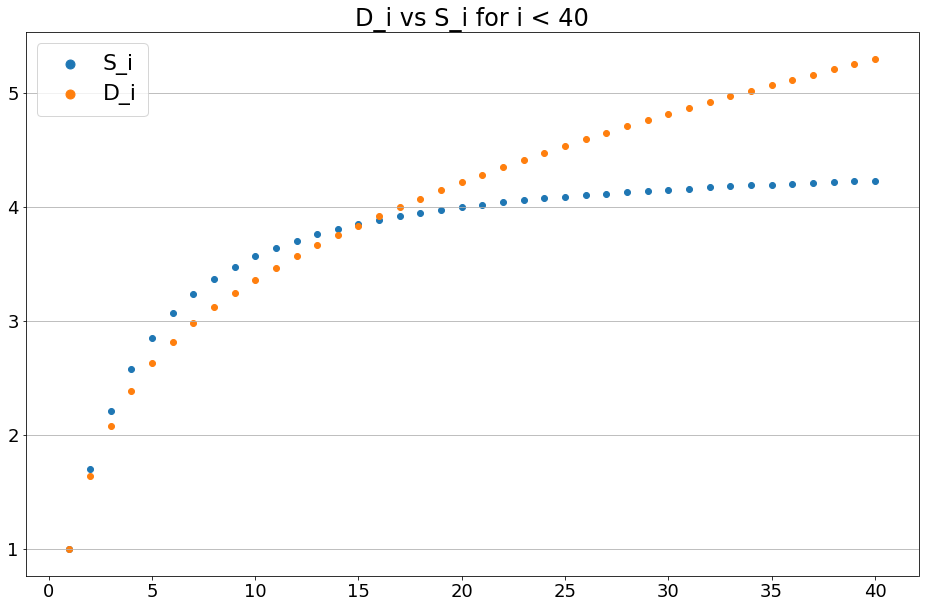

In [232]:

plt.title("D_i vs S_i for i < %i" % k)

plt.scatter(range(1, k + 1), same, label="S_i")
plt.scatter(range(1, k + 1), diff, label="D_i")
plt.grid(axis='y')

plt.legend()

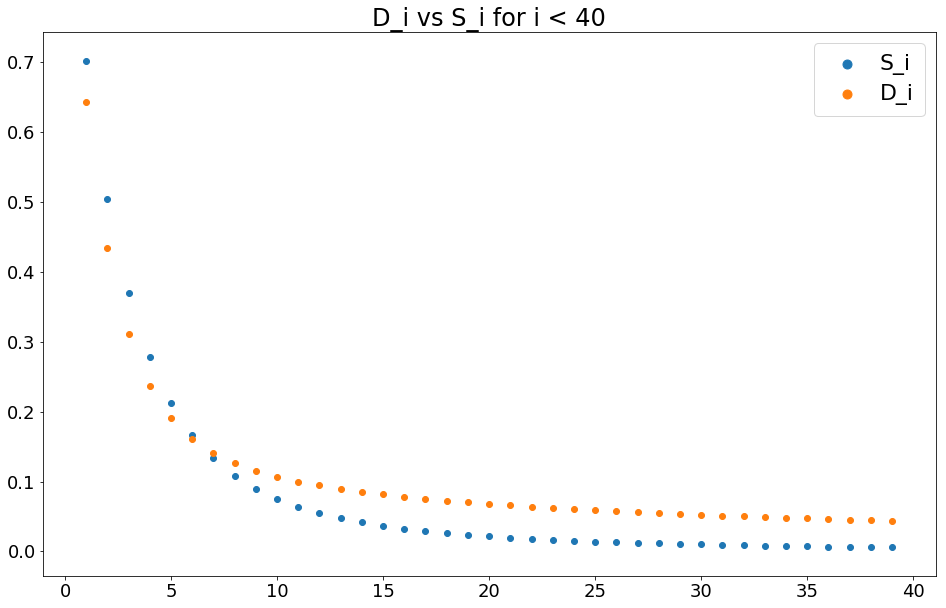

In [233]:
plt.title("D_i vs S_i for i < %i" % k)




plt.scatter(range(1, k), same[1:] - same[:-1], label="S_i")
plt.scatter(range(1, k), diff[1:] - diff[:-1], label="D_i")




plt.legend()

### Plot elements of sums for different n

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

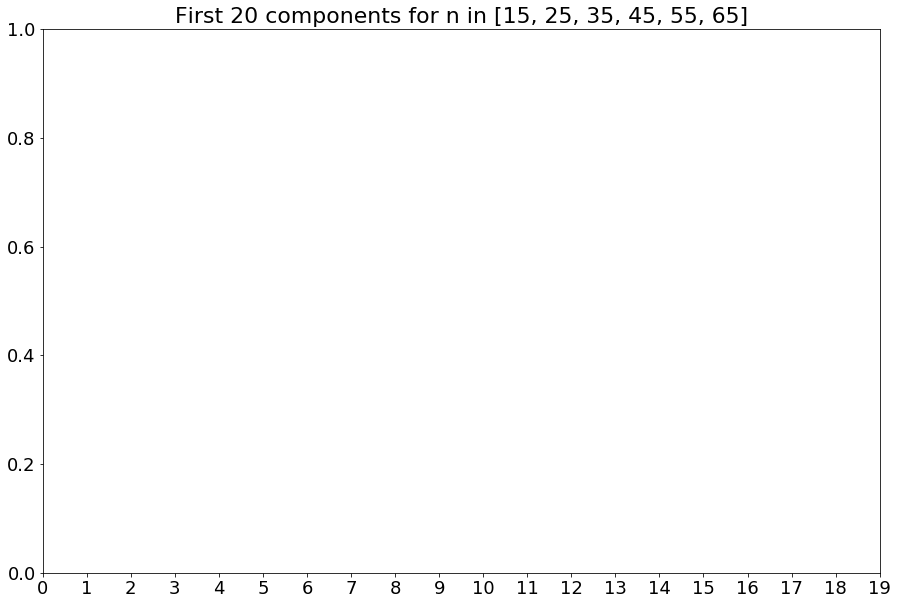

IndexError: invalid index to scalar variable.

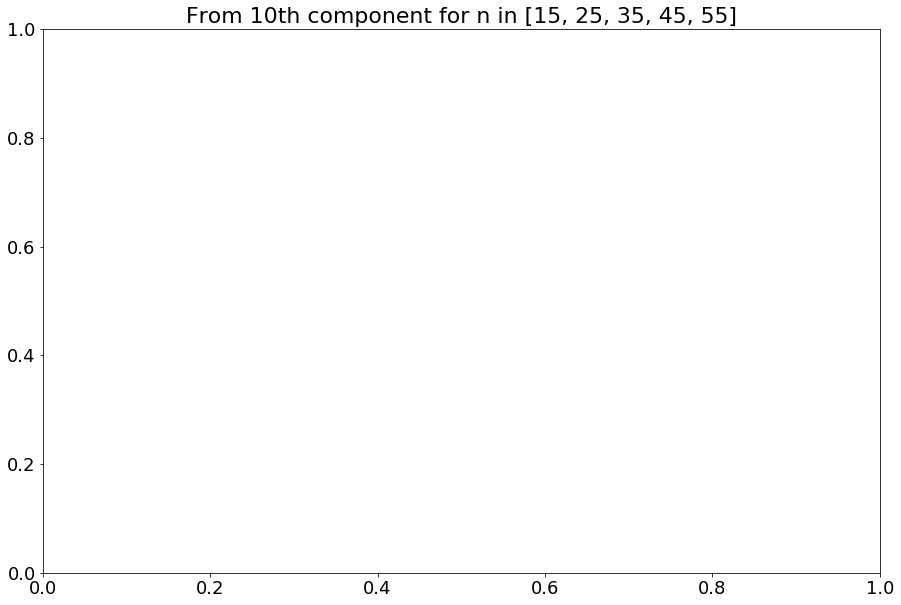

In [235]:
indices = [15, 25, 35, 45, 55]

border = 10

plt.figure(figsize=(15, 10))
plt.title("From " + str(border) + "th component for n in " + str(indices), fontsize=22)

plt.plot(range(border, max(indices) + 1), same_prices_vec[max(indices)][border:], label="S_%i" % max(indices), linewidth=7.0, alpha=0.4)
plt.scatter(range(border, max(indices) + 1), same_prices_vec[max(indices)][border:], label="S_%i" % max(indices), alpha=0.4)


max_ind = max(indices)
for i in indices[::-1]:
    if i > border:
        plt.plot(range(border, i + 1), different_prices_vec[i][border:], label="D_" + str(i))
        plt.scatter(range(border, i + 1), different_prices_vec[i][border:])
    
plt.legend()
plt.show()

## Same plots for other G = U[0.05, 0.1]

In [238]:
n = 70

In [239]:
different_prices_vec, same_prices_vec, diff_prices_vec_sum, same_prices_vec_sum = ComputeVectorsAndSums(n,
                                                                                                       UniformCDF([0, 0.1]))

### Plots start here

### D_i vs S_i

In [240]:
k = 40

assert k < n
same = same_prices_vec_sum[:k]
diff = diff_prices_vec_sum[:k]

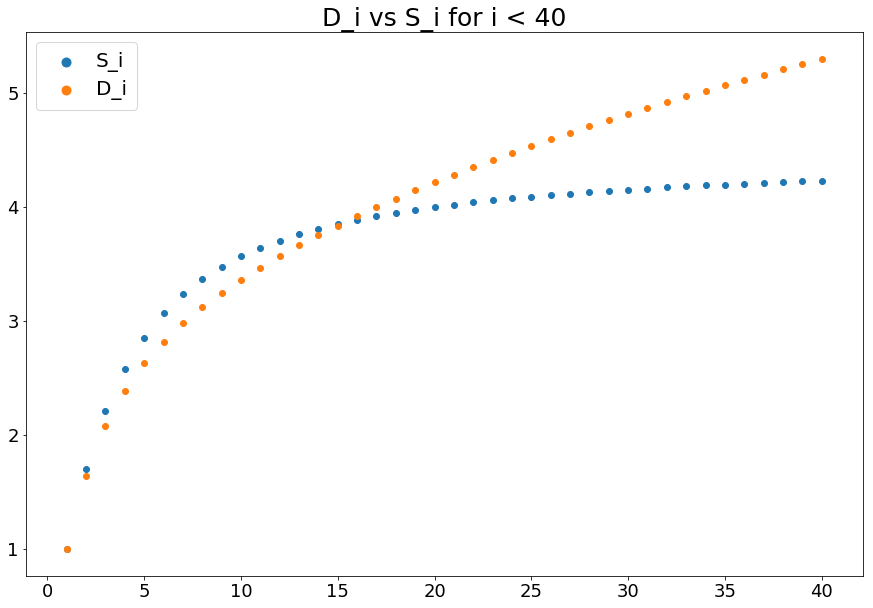

In [241]:
plt.figure(figsize=(15, 10))
plt.title("D_i vs S_i for i < %i" % k, fontsize=25)

plt.scatter(range(1, k + 1), same, label="S_i")
plt.scatter(range(1, k + 1), diff, label="D_i")

plt.legend(fontsize=20)

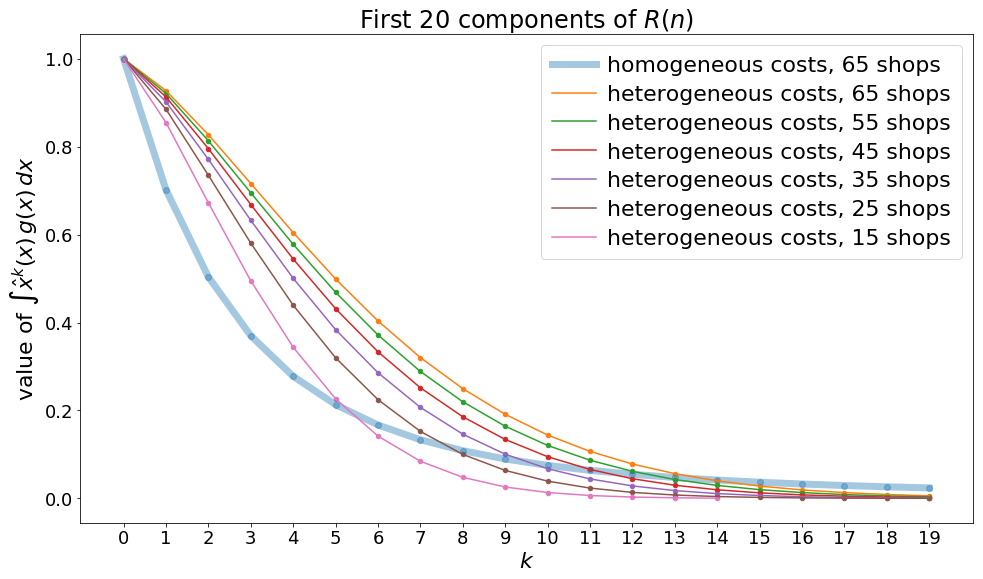

In [254]:
indices = [15, 25, 35, 45, 55, 65]
border = 20

plt.figure(figsize=(16, 9))
plt.title("First " + str(border) + " components of $R(n)$")
plt.xticks(range(border))

plt.plot(range(border), same_prices_vec[border - 1], label="homogeneous costs, %i shops" % 65,
         linewidth=7.0, alpha=0.4)
plt.scatter(range(border), same_prices_vec[border - 1], alpha=0.4)

for i in indices[::-1]:
    cur_border = min(border, i)
    plt.plot(range(cur_border), different_prices_vec[i][:cur_border], label="heterogeneous costs, %i shops" % i)
    plt.scatter(range(cur_border), different_prices_vec[i][:cur_border], s=20)
    
plt.ylabel("value of $\int \hat{x}^k(x)\,g(x)\, d x$")
plt.xlabel("$k$")
    
plt.legend(fontsize=22)
plt.show()

## Plots for optimal prices

In [199]:
same_prices_vec = []
different_prices_vec = []

n = 70
for i in tqdm(range(1, n)):
    x, y = solution_for_same_and_different_search_costs(i)
    same_prices_vec.append(x)
    different_prices_vec.append(y)

100%|██████████| 69/69 [01:59<00:00,  1.73s/it]


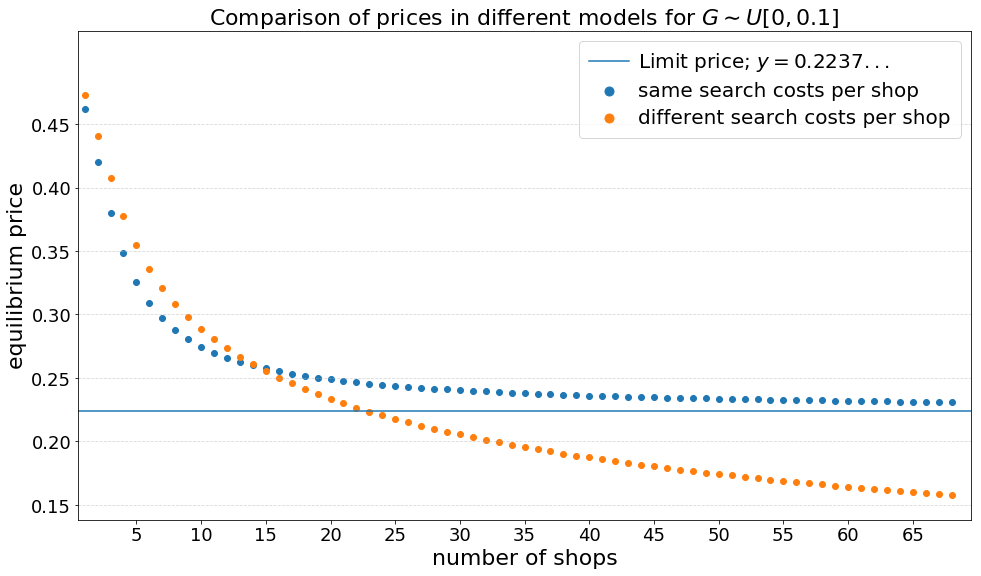

In [206]:
n = 69

plt.figure(figsize=(16, 9))
plt.scatter(range(n), same_prices_vec[:n], label="same search costs per shop")
plt.scatter(range(n), different_prices_vec[:n], label="different search costs per shop")
plt.xticks(np.arange(0, n + 1, 5))
plt.xlim(1 - 0.5, n + .5)

plt.axhline(y=0.2237, label="Limit price; $y=0.2237...$")

min1 = min(same_prices_vec[:n])
min2 = min(different_prices_vec[:n])


plt.xlabel("number of shops")
plt.ylabel("equilibrium price")


plt.title("Comparison of prices in different models for $G \sim U[0, 0.1]$", fontsize=22)

# plt.yticks(np.arange(min(min1, min2) - 0.02, 0.51, 0.03))

plt.yticks(np.arange(0.15, 0.5, 0.05))

plt.grid(axis='y', alpha=0.5, ls='--')

plt.legend(fontsize=20)

In [218]:
n = 100

In [219]:
for i in range(1, n):
        x, y = solution_for_same_and_different_search_costs(i, UniformCDF([0.06, 0.08]))
        
        if i % 5 == 0:
            print(x, y)
        if y < x:

            print(i)
            array.append(i)
            break

1.0344495918733538 1.0344495918733538
1.136533173932803 1.136533173932803
1.2378809928071353 1.2378809928071353
1.3235945542559007 1.3235945542559007
1.3866720227051663 1.3866720227051663
1.4294797243527904 1.4294797243527904
1.4570627884950667 1.4570627884950667
1.4742547023992456 1.4742547023992456
1.4847495092715195 1.4847495092715195
1.4910749644929775 1.4910749644929775
1.4948582245071707 1.4948582245071707
1.4971105861777831 1.4971105861777831
1.498447849060947 1.498447849060947
1.4992405084195082 1.4992405084195082
1.499709900844715 1.499709900844715
1.499987703641193 1.499987703641193
1.5001520612429236 1.5001520612429236
1.500249281282183 1.500249281282183
1.5003067815960018 1.5003067815960018


In [9]:
array = []
n = 50

for t in np.arange(0, 0.1, 0.02):
    print(t)    
    ggg = UniformCDF([t, t + 0.02])
    


0.0
0.02
0.04
0.06
0.08


In [67]:
array = []
n = 50

for t in np.arange(0.02, 0.03, 0.01):
    print(t)    
    ggg = UniformCDF([0.1 - t, 0.1 + t])
    for i in range(1, n):
        x, y = solution_for_same_and_different_search_costs(i, ggg)
        if y < x:
            print(i)
            array.append(i)
            break


0.0


/home/alexander/thesis/ProbabilityTheory.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  super().__init__(lambda x : (x - l) / (r - l), bounds)


0.01
7
0.02
7


/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [ ]:
array = []
n = 50

for t in np.arange(0., 0.03, 0.01):
    print(t)    
    ggg = UniformCDF([0.03 - t, 0.1 + t])
    for i in range(1, n):
        x, y = solution_for_same_and_different_search_costs(i, ggg)
        if y < x:
            print(i)
            array.append(i)
            break


In [59]:
for t in np.arange(0.015, 0.07, 0.015):
    print("'$U[%.3f, %.3f]$', " % (0.06 - t, 0.06 + t), end=' ')

'$U[0.045, 0.075]$',  '$U[0.030, 0.090]$',  '$U[0.015, 0.105]$',  '$U[0.000, 0.120]$',  

In [61]:
array_1 = [14, 13, 10, 8, 7]

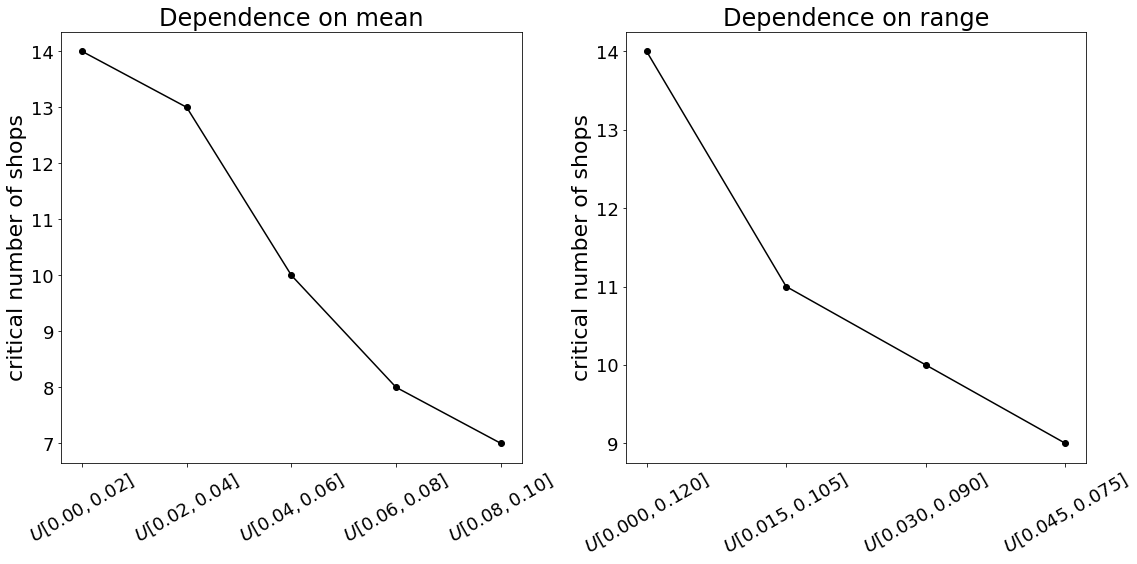

In [66]:
plt.figure(figsize=(16, 8))

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(1, 2, 1)
plt.plot(array_1, 'ko-')

plt.xticks(np.arange(5),
           ['$U[0.00, 0.02]$', '$U[0.02, 0.04]$','$U[0.04, 0.06]$','$U[0.06, 0.08]$','$U[0.08, 0.10]$',],
           rotation=30)
plt.title('Dependence on mean')
plt.ylabel('critical number of shops')




plt.subplot(1, 2, 2)
plt.plot(array[::-1], 'ko-')
plt.title('Dependence on range')
plt.ylabel('critical number of shops')

plt.xticks(np.arange(4),
           ['$U[0.045, 0.075]$',  '$U[0.030, 0.090]$',  '$U[0.015, 0.105]$',  '$U[0.000, 0.120]$', ][::-1],
           rotation=30)


plt.tight_layout()
plt.show()

In [ ]:
plt.

In [12]:
array = [14, 13, 10, 8, 7]

In [ ]:
[25, 12, 9, 8,]

In [14]:
array

[25, 12, 9, 8, 7, 7]

In [48]:
same_prices_vec = []
different_prices_vec = []

n = 40
for i in tqdm(range(1, n)):
    x, y = solution_for_same_and_different_search_costs(i, G=UniformCDF(bounds=[0, 0.05]))
    same_prices_vec.append(x)
    different_prices_vec.append(y)

100%|██████████| 39/39 [00:58<00:00,  1.51s/it]


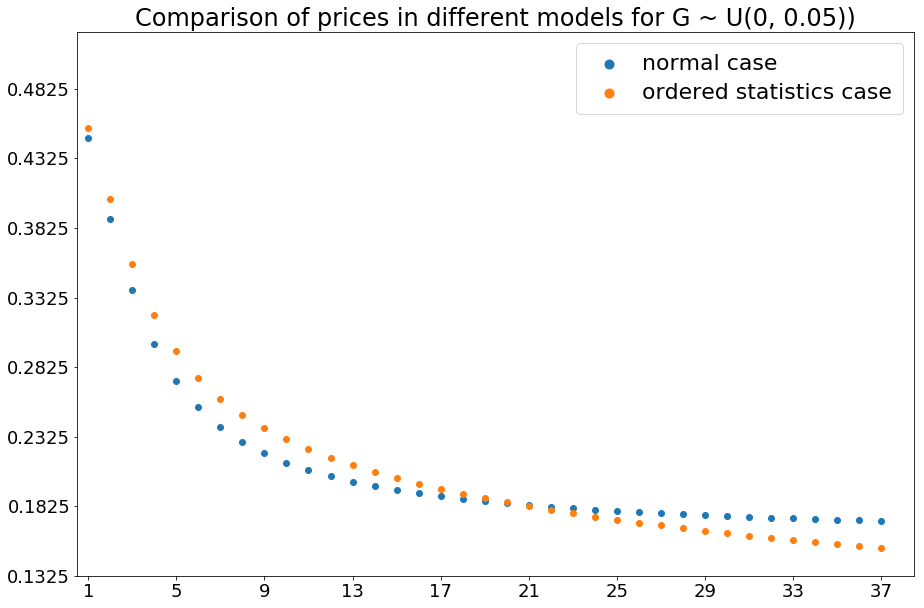

In [50]:
n = n - 1
plt.figure(figsize=(15, 10))
plt.scatter(range(n), same_prices_vec[:n], label="normal case")
plt.scatter(range(n), different_prices_vec[:n], label="ordered statistics case")
plt.xticks(np.arange(1, n + 1, 4))
plt.xlim(1 - 0.5, n + .5)

min1 = min(same_prices_vec[:n])
min2 = min(different_prices_vec[:n])


plt.title("Comparison of prices in different models for G ~ U(0, 0.05))")
plt.yticks(np.arange(min(min1, min2) - 0.02, 0.51, 0.05))

plt.legend()

In [52]:
same_prices_vec = []
different_prices_vec = []

n = 40
for i in tqdm(range(1, n)):
    x, y = solution_for_same_and_different_search_costs(i, G=UniformCDF(bounds=[0.05, 0.1]))
    same_prices_vec.append(x)
    different_prices_vec.append(y)

    

100%|██████████| 39/39 [00:57<00:00,  1.46s/it]


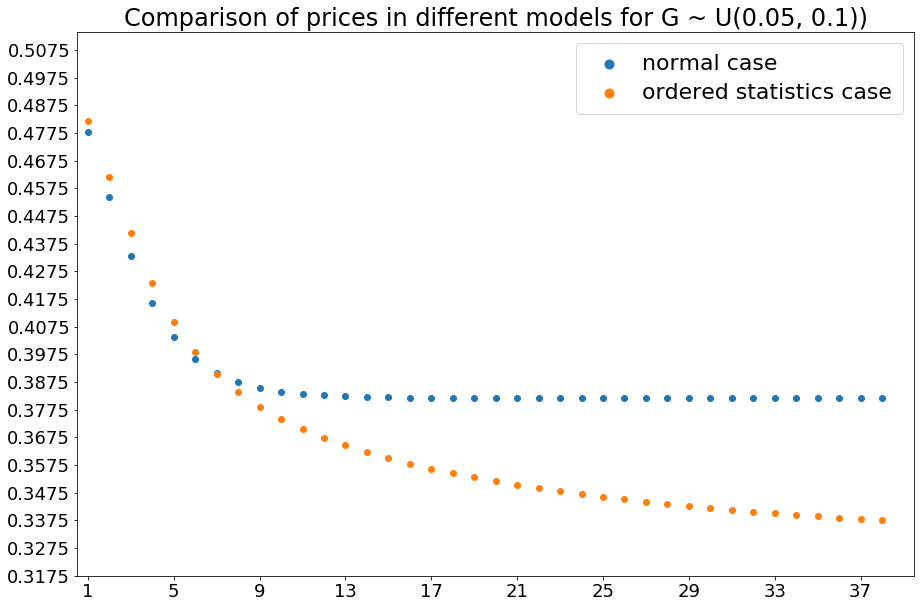

In [53]:
n = n - 1
plt.figure(figsize=(15, 10))
plt.scatter(range(n), same_prices_vec[:n], label="normal case")
plt.scatter(range(n), different_prices_vec[:n], label="ordered statistics case")
plt.xticks(np.arange(1, n + 1, 4))
plt.xlim(1 - 0.5, n + .5)

min1 = min(same_prices_vec[:n])
min2 = min(different_prices_vec[:n])


plt.title("Comparison of prices in different models for G ~ U(0.05, 0.1))")
plt.yticks(np.arange(min(min1, min2) - 0.02, 0.51, 0.01))

plt.legend()

## x_hat_inverse and x_hat

In [6]:
def Get_x_hat_inverse_and_x_hat(F, verbose=False):
    def one_minus_F(x): return 1 - F(x)

    if verbose:
        plt.figure(figsize=(16, 10))
        x = np.linspace(F.left_bound, F.right_bound, 100)
        plt.plot(x, F(x), label="F(x)")
        plt.plot(x, one_minus_F(x), label="1 - F(x)")

    x = np.linspace(F.left_bound, F.right_bound, 1000)
    y = [integrate.quad(one_minus_F, max(0., t), F.right_bound + 1)[0]
         for t in x
         ]

    expected_value = y[0]
#     print(expected_value -  ExpectedValue(F))
#     assert(abs(expected_value -  ExpectedValue(F)) <  0.00000001 )

    x_hat_inverse = interpolate.interp1d(x, y)
    x_hat = interpolate.interp1d(y, x)

    if verbose:
        plt.scatter(x, y)

        x = np.linspace(0, expected_value, 100)
        plt.plot(x, x_hat(x), label="x_hat Integral 1 - F(t) from x to inf")
        plt.legend()

    def new_hat_inverse(x):
        x = np.asarray(x)
        return np.where(x <  F.left_bound + EPS, x_hat_inverse(F.left_bound + EPS),
                       np.where(x > F.right_bound - 0.001, x_hat_inverse(F.right_bound - 0.001),
                               x_hat_inverse(x)))
    
    def new_hat(x):
        x = np.asarray(x)
        return np.where(x <  0 + EPS, x_hat(EPS),
                       np.where(x > expected_value - EPS, x_hat(expected_value - EPS),
                               x_hat(x)))
    
    return Function(new_hat_inverse, [F.left_bound, F.right_bound]), \
           Function(new_hat, [0, expected_value])

## Two Shops

In [400]:
F =  UniformCDF()
f = CDF_to_PDF(F)

hat_inv, hat =  Get_x_hat_inverse_and_x_hat(F)

assert ((hat_inv(hat(0.2341)) - 0.2341)**2 < 0.001) 
assert ((hat(hat_inv(0.2341)) - 0.2341)**2 < 0.001) 

In [401]:
price_equilibrium = 0.4

In [402]:
def demand(p, c2, p_equi):
    if p_equi > hat(c2):
        return 0
        print(hat(c2))
        assert(False)

    def integrand(x):
        return F(x) * f(x - p_equi + p)

    inside_brackets = hat(c2) - p_equi + p

    return (1 + F(hat(c2))) * (1 - F(inside_brackets)) \
            + 2 * integrate.quad(integrand, p_equi, hat(c2))[0]


def demand_changed_variables(p, c2, p_equi):
#     if p_equi > hat(c2):
#         return 0
#         print(hat(c2))
#         assert(False)
    
#     assert(p_equi > c2)
    
    def integrand(x):
        return  F(x) * f(x - p_equi  + p)
    
    inside_brackets = c2 - p_equi + p
    
    return ((1 + F(c2)) * (1 - F(inside_brackets))
            + 2 * integrate.quad(integrand, p_equi, c2)[0])

def demand_changed_variables_extended(p, c2, p_equi):
#     if p_equi > c2:
#         print(hat(c2))
#         assert(False)
#         return 0
        
    def integrand(x):
        return  F(x) * f(x - p_equi  + p)
    
    inside_brackets = c2 - p_equi + p
    
    return (1 + F(c2)) * (1 - F(inside_brackets)) + 2 * integrate.quad(integrand, p_equi, c2)[0], \
            (1 + F(c2)) * (1 - F(inside_brackets)), \
             2 * integrate.quad(integrand, p_equi, c2)[0]

def derivative_c(p, c2, p_equi):
    inside_brackets = c2 - p_equi + p
    
    return (1 - F(inside_brackets)) * f(c2) - (1 - F(c2)) * f(inside_brackets)

def derivative_p(p, c, p_equi):
    inside_brackets = c - p_equi + p
    
    return (1 + F(c)) * -f(inside_brackets) \
            - 2* F(p_equi - p) * (c < p_equi - p) * (p_equi - p < p_equi) \
            + 2* F(p_equi - p + 1) * (c < p_equi - p + 1) * (p_equi - p + 1 < p_equi)

In [403]:
def CalculateRaw(price_equilibrium):
    n_prices = 10
    n_costs = 10

    prices = np.linspace(0, 0.5, n_prices)
    costs =  np.linspace(0, 0.1, n_costs)

    x, y = np.meshgrid(prices, costs)

    matrix = np.zeros((n_prices, n_costs))
    matrix_deriv_c = np.zeros((n_prices, n_costs))

    for i in range(n_prices):
        for j in range(n_costs):
            matrix[i][j] = demand(prices[i], costs[j], price_equilibrium)
            
    return matrix.mean(axis=1) * prices

In [404]:
n_prices = 10

In [405]:
prices = np.linspace(0, 0.5, n_prices)

In [406]:
prices

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ])

In [407]:
matrix = np.zeros((n_prices, n_prices))

for i in tqdm(range(n_prices)):
    matrix[i] = CalculateRaw(prices[i])

 10%|█         | 1/10 [00:02<00:18,  2.08s/it]


TypeError: iteration over a 0-d array

In [269]:
matrix

array([[0.        , 0.05028812, 0.09010997, 0.1196173 , 0.13918392,
        0.14946752, 0.15142671, 0.14669395, 0.13722594, 0.12495   ],
       [0.        , 0.05538409, 0.10023331, 0.13465056, 0.15880387,
        0.17312257, 0.17833221, 0.17546441, 0.16627849, 0.15283931],
       [0.        , 0.06015364, 0.10973937, 0.14880676, 0.17747646,
        0.19593282, 0.20466068, 0.20445343, 0.19641532, 0.18243368],
       [0.        , 0.06458027, 0.11859261, 0.16203704, 0.19497966,
        0.21755888, 0.22997535, 0.2327694 , 0.22680235, 0.21325114],
       [0.        , 0.06866395, 0.12675998, 0.17428809, 0.21124829,
        0.2377232 , 0.25386993, 0.25990265, 0.25641997, 0.24435017],
       [0.        , 0.0724047 , 0.13424148, 0.18551035, 0.22621129,
        0.25634431, 0.27600858, 0.28537805, 0.28468592, 0.27458358],
       [0.        , 0.07580252, 0.14103711, 0.19570379, 0.23980255,
        0.27333338, 0.2962963 , 0.30880699, 0.31105718, 0.30329636],
       [0.        , 0.0788574 , 0.1471468

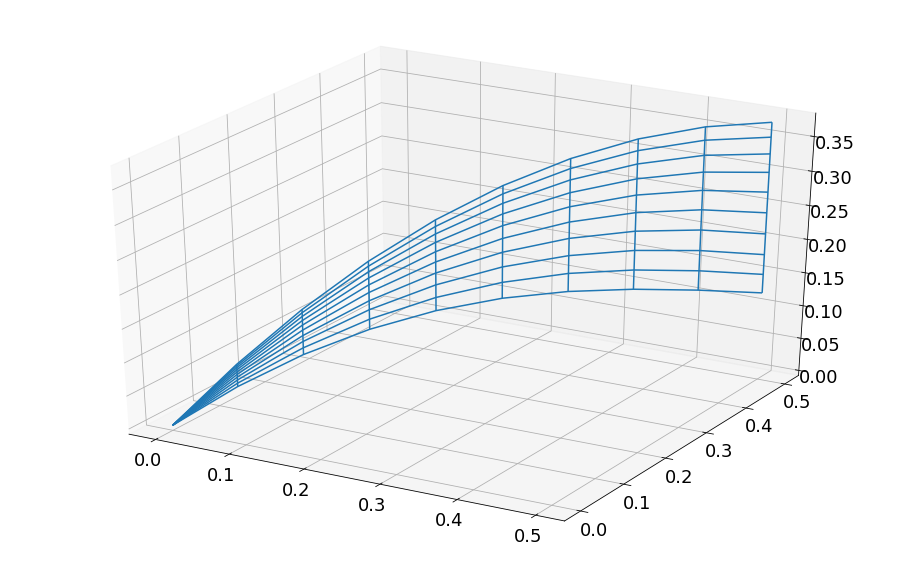

In [270]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(np.matrix([prices] *  len(prices)),
                  np.matrix([prices] *  len(prices)),
                  matrix , rstride=1, cstride=1)

plt.show()

In [271]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

In [272]:
data

NameError: name 'data' is not defined

In [273]:

data = [
    go.Surface(
        z=matrix, 
    )
]
layout = go.Layout(
    autosize=True,
    scene=dict(
        xaxis = dict(
#             nticks=4, range = [0, 0.5],
          title="Price"),
        yaxis = dict(
            title="Equilibrium Price"
#             nticks=4, range = [0,0.5],
        ),
#         zaxis = dict(
#             nticks=4, range = [-100,100],),
    ),
    width=1000,
    height=1000,
    margin=dict(
        l=100,
        r=100,
        b=100,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [33]:
CalculateRaw(0.43)

array([0.        , 0.08089722, 0.15122653, 0.21098791, 0.26018138,
       0.29880692, 0.32686454, 0.34435425, 0.35128402, 0.34786788])

In [410]:
n_prices = 5
n_costs = 100

prices = np.linspace(0, 0.5, n_prices)
costs =  np.linspace(0, 0.1, n_costs)

x, y = np.meshgrid(prices, costs)

matrix = np.zeros((n_prices, n_costs))
matrix_deriv_c = np.zeros((n_prices, n_costs))

for i in range(n_prices):
    for j in range(n_costs):
        matrix[i][j] = demand(prices[i], costs[j], price_equilibrium)
        matrix_deriv_c[i][j] = derivative_c(prices[i], costs[j], price_equilibrium)

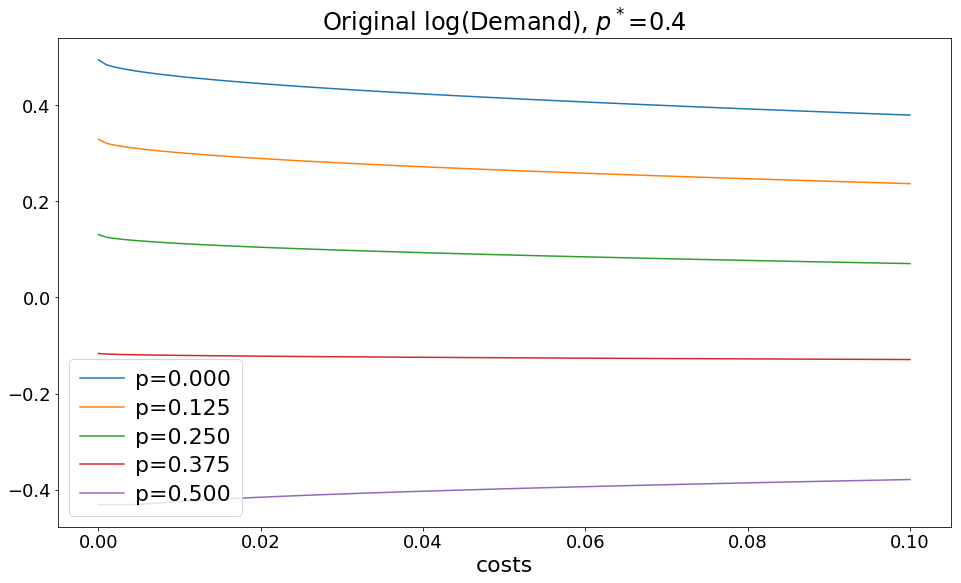

In [411]:
plt.figure(figsize=(16, 9))
plt.xlabel("costs")
plt.title("Original log(Demand), $p^*$=" + str(price_equilibrium))

for i in range(0, len(matrix)):
#     label_ = "p > p^* GOOD" if (prices[i] > price_equilibrium) else "p < p^* BAD"
    label_ = "p=%.3f" % prices[i]
    plt.plot(costs, np.log(matrix[i]), label=label_)
#     plt.plot(costs, matrix_deriv_c[i] / 20 + 1.2)
    
plt.legend(loc='best')

In [36]:
n_prices = 5
n_costs = 100

prices = np.linspace(0, 0.5, n_prices)
costs =  np.linspace(0.5, 1, n_costs)

x, y = np.meshgrid(prices, costs)

matrix = np.zeros((n_prices, n_costs))
matrix_deriv_c = np.zeros((n_prices, n_costs))

for i in range(n_prices):
    for j in range(n_costs):
        matrix[i][j] = demand_changed_variables(prices[i], costs[j], price_equilibrium)
        matrix_deriv_c[i][j] = derivative_c(prices[i], costs[j], price_equilibrium)

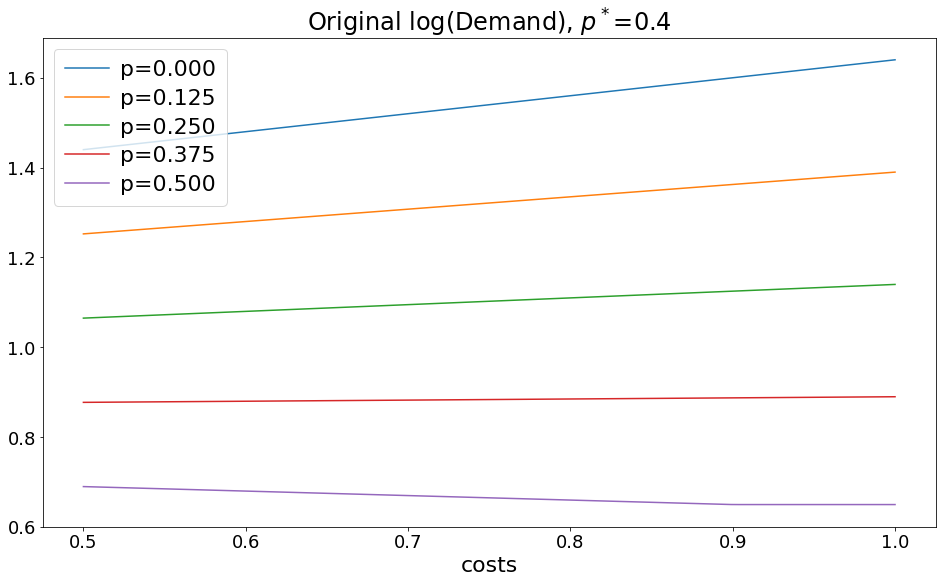

In [37]:
plt.figure(figsize=(16, 9))
plt.xlabel("costs")
plt.title("Original log(Demand), $p^*$=" + str(price_equilibrium))

for i in range(0, len(matrix)):
#     label_ = "p > p^* GOOD" if (prices[i] > price_equilibrium) else "p < p^* BAD"
    label_ = "p=%.3f" % prices[i]
    plt.plot(costs, matrix[i], label=label_)
#     plt.plot(costs, matrix_deriv_c[i] / 20 + 1.2)
    
plt.legend(loc='best')

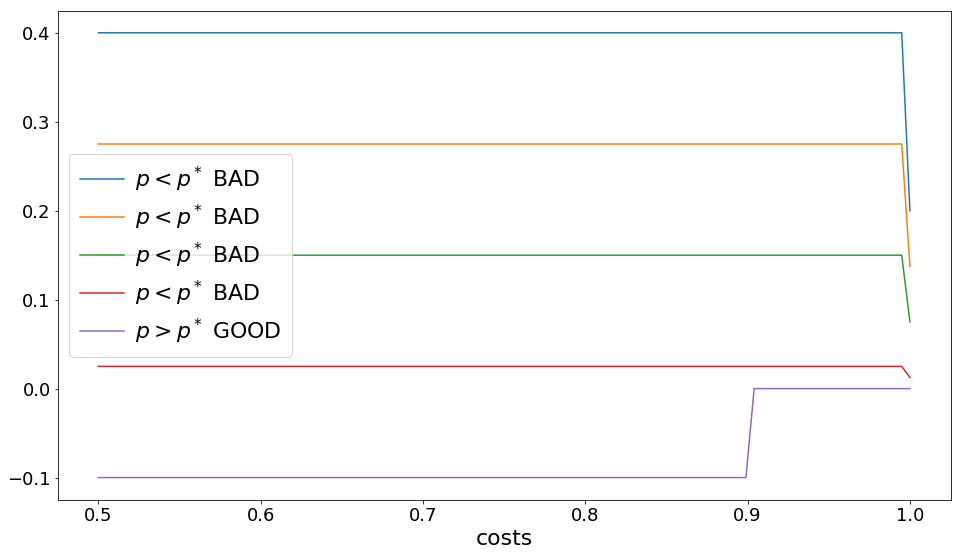

In [38]:
plt.figure(figsize=(16, 9))
plt.xlabel("costs")

for i in range(0, len(matrix)):
    label_ = "$p > p^*$ GOOD" if (prices[i] > price_equilibrium) else "$p < p^*$ BAD"
    plt.plot(costs, matrix_deriv_c[i], label=label_)
    
plt.legend(loc='best')

In [39]:
hat(0)

array(0.99799778)

In [40]:
n_prices = 200
n_costs = 10

prices = np.linspace(0, 0.5, n_prices)
costs =  np.linspace(0.55, 1, n_costs)

x, y = np.meshgrid(prices, costs)

matrix = np.zeros((n_prices, n_costs))
matrix_deriv_c = np.zeros((n_prices, n_costs))
matrix_deriv_p = np.zeros((n_prices, n_costs))


for i in range(n_prices):
    for j in range(n_costs):
        matrix[i][j] = demand_changed_variables(prices[i], costs[j], price_equilibrium)
#         matrix_deriv_c[i][j] = derivative_c(prices[i], costs[j], price_equilibrium)
        matrix_deriv_p[i][j] = derivative_p(prices[i], costs[j], price_equilibrium)

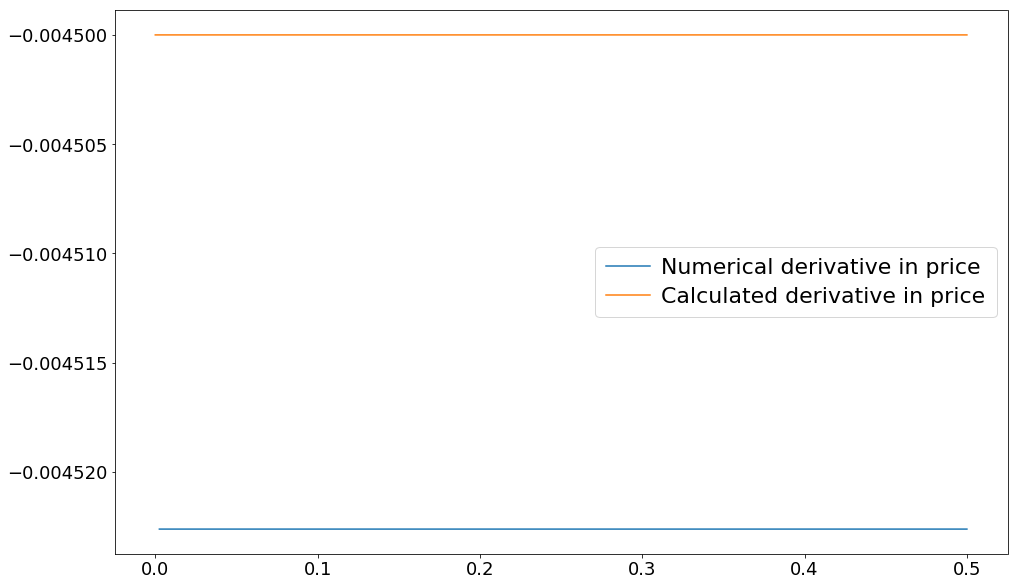

In [41]:

plt.plot(prices[1:], matrix[1:, 5] - matrix[:-1, 5], label="Numerical derivative in price")
plt.plot(prices, matrix_deriv_p[:, 5] / 400, label="Calculated derivative in price")
plt.legend()
    

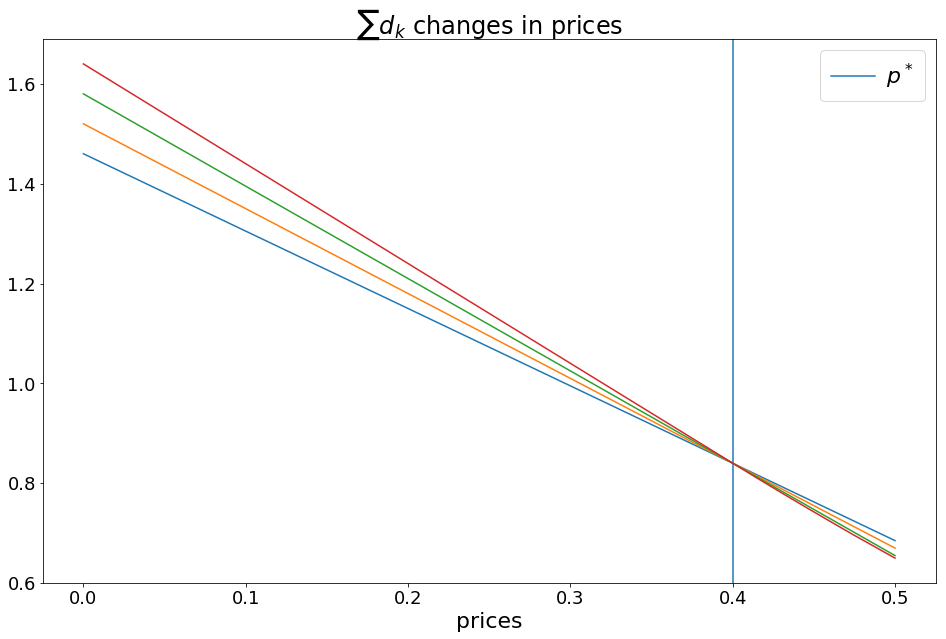

In [42]:
plt.title("$\sum d_k$ changes in prices")
plt.xlabel("prices")

plt.axvline(x=price_equilibrium, label="$p^*$")

for i in range(0, len(matrix[0]), 3):
    plt.plot(prices, matrix[:, i])
#     plt.plot(prices, matrix_deriv_p[:, i])
    
plt.legend()


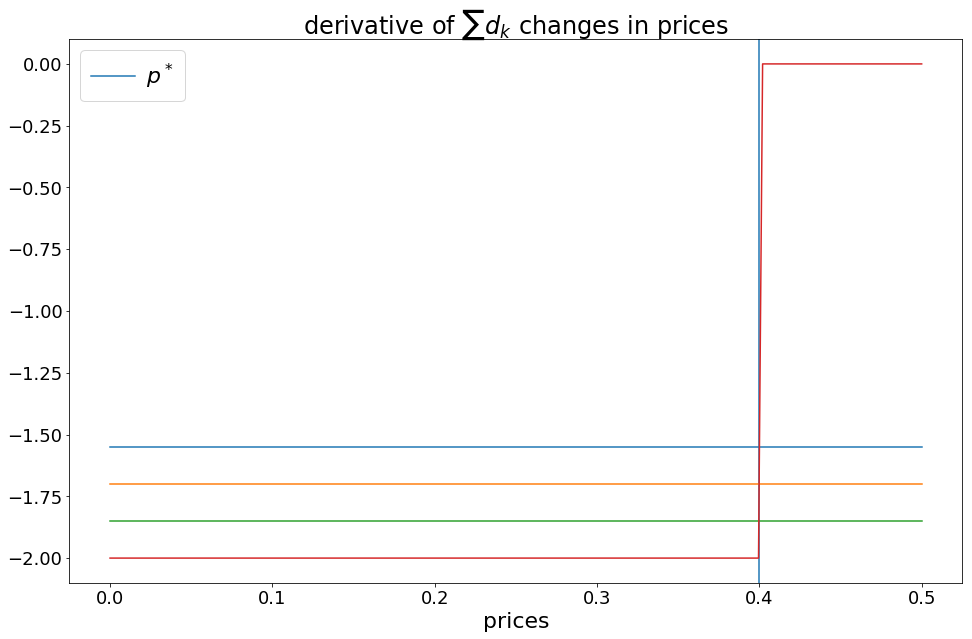

In [43]:
plt.title("derivative of $\sum d_k$ changes in prices")
plt.xlabel("prices")

plt.axvline(x=price_equilibrium, label="$p^*$")

for i in range(0, len(matrix[0]), 3):
#     plt.plot(prices, matrix[:, i])
    plt.plot(prices, matrix_deriv_p[:, i])
    
plt.legend()


In [44]:
n_prices = 20
n_costs = 20

prices = np.linspace(0, 0.5, n_prices)
costs =  np.linspace(0, 1, n_costs)

x, y = np.meshgrid(prices, costs)

matrix = np.zeros((n_prices, n_costs))
matrix_deriv_c = np.zeros((n_prices, n_costs))
matrix_deriv_p = np.zeros((n_prices, n_costs))


for i in range(n_prices):
    for j in range(n_costs):
        matrix[i][j] = demand_changed_variables(prices[i], costs[j], price_equilibrium)
#         matrix_deriv_c[i][j] = derivative_c(prices[i], costs[j], price_equilibrium)
        matrix_deriv_p[i][j] = derivative_p(prices[i], costs[j], price_equilibrium)

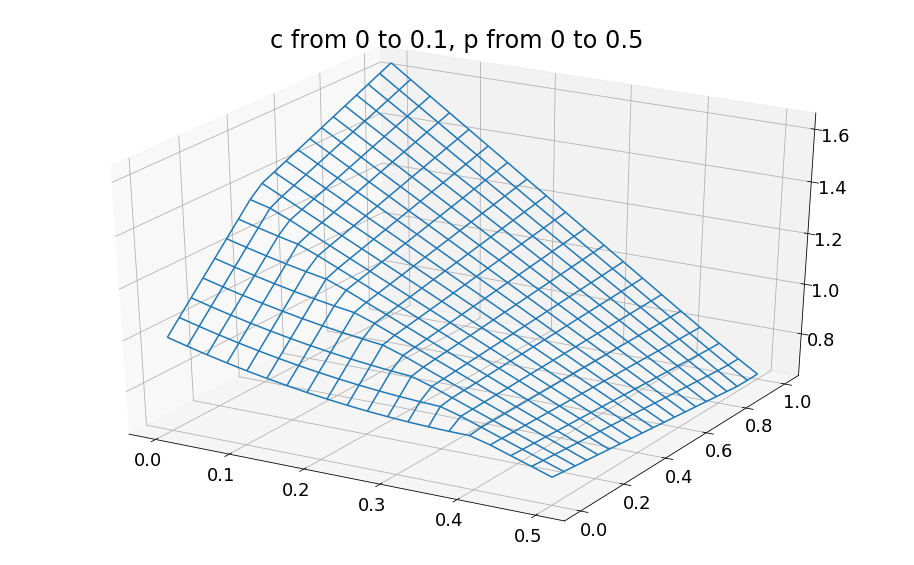

In [46]:

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.title("c from 0 to 0.1, p from 0 to 0.5")
# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(np.matrix([prices] *  len(costs)).T,
                  np.matrix([costs] * len(prices)),
                  matrix , rstride=1, cstride=1)

plt.show()

## Two shops Equilibrium Price

In [358]:
del x

In [7]:
def RHS(F, G, verbose=True, number_of_points=1000, full_verbose=False):
    
    hat_inv, hat = Get_x_hat_inverse_and_x_hat(F)
    
    f = CDF_to_PDF(F)
    g = CDF_to_PDF(G)
    f_deriv = Derivative(f)
    
    g_1 = k_statistics_PDF(1, 2, G, g)
    g_2 = k_statistics_PDF(2, 2, G, g)
    
    G_1 = k_statistics_CDF(1, 2, G)
    G_2 = k_statistics_CDF(2, 2, G)
    
    
    def func_k_equals_one(x):
        x = np.asarray(x)
        return f(hat(x)) * g_1(x) \
                + f_deriv(hat_inv(x)) * hat_inv(x) * G_1(x)
       
    def func_k_equals_two(x):
        x = np.asarray(x)
        return F(hat(x)) * f(x) * g_2(x) \
               + (f_deriv(hat_inv(x)) * (2* F(hat_inv(x)) - 1)
                  * (F(x) - 1) * G_2(x))    
        

    def func(c):
        c = np.asarray(c)
        return func_k_equals_one(c) + func_k_equals_two(c) 
    
    
    if full_verbose:
        x = np.linspace(F.left_bound, F.right_bound, number_of_points)

        plt.plot(x, F(x), label="F")
        plt.plot(x, f(x), label="f")
        plt.plot(x, f_deriv(x), label="f_deriv")
        plt.ylim(-5, 5)
        plt.legend()
        plt.show()

        x = np.linspace(hat.left_bound, hat.right_bound, number_of_points)    
        plt.plot(x, hat(x), label="hat")
        x = np.linspace(hat_inv.left_bound, hat_inv.right_bound, number_of_points)
        plt.plot(x, hat_inv(x), label="hat_inv")
        plt.legend()
        plt.show()

        x = np.linspace(G.left_bound, G.right_bound, number_of_points)
        plt.plot(x, G(x), label="G")
        plt.plot(x, G_1(x), label="G_1")
        plt.plot(x, G_2(x), label="G_2")
        plt.legend()
        plt.show()

        plt.plot(x, g(x), label="g")
        plt.plot(x, g_1(x), label="g_1")
        plt.plot(x, g_2(x), label="g_2")
        plt.legend()
        plt.show()

    if verbose:
        x = np.linspace(G.left_bound, G.right_bound, number_of_points)
        plt.plot(x, func_k_equals_one(x), label="func_k_equals_one")
        plt.legend()
        plt.plot()

        plt.plot(x, func_k_equals_two(x), label="func_k_equals_two")
        plt.legend()
        plt.plot()

        plt.plot(x, func(x), label="func")
        plt.legend()
        plt.plot()
    
    
    def func_second(x):
        x = np.asarray(x)
        return      (f(hat(x)) * (1 + F(hat(x))))* g_2(x) + \
                 f_deriv(hat_inv(x)) * F(hat_inv(x)) * G_2(x) 
    

    
    return integrate.quad(func_second, G.left_bound, G.right_bound)[0]
#         integrate.quad(func_second, G.left_bound, G.right_bound)[0]

In [59]:
hat.right_bound

NameError: name 'hat' is not defined

In [8]:
def RHS_n_shops(F, G, n):
    
    hat_inv, hat = Get_x_hat_inverse_and_x_hat(F)
    
    f = CDF_to_PDF(F)
    g = CDF_to_PDF(G)
    f_deriv = Derivative(f)
    
    
    def func_k_equals_one(x):
        x = np.asarray(x)
        g_1 = k_statistics_PDF(1, n, G, g)
        G_1 = k_statistics_CDF(1, n, G)
        
        return f(hat(x)) * g_1(x) \
                + f_deriv(hat_inv(x)) * hat_inv(x) * G_1(x)
       
    def func_k_equals_i(x, i):
        x = np.asarray(x)
        g_i = k_statistics_PDF(i, n, G, g)
        G_i = k_statistics_CDF(i, n, G)
    
        return F(hat(x))**(i-1) * f(x) * g_i(x) \
               + (f_deriv(hat_inv(x)) * (1 - F(x)) * G_i(x)
                  *((i - 1) * F(hat_inv(x))**(i-2) - i * F(hat_inv(x))**(i-1)))    
        

        
    def func(c):
        c = np.asarray(c)
        if k == 1:
            return func_k_equals_one(c)
        elif k > 1:
            return func_k_equals_i(c, k)
        
    
    answer = [
        integrate.quad(func_k_equals_one, G.left_bound, G.right_bound)[0]
    ]
    
    for i in range(2, n+1):
        value = integrate.quad(func_k_equals_i, G.left_bound, G.right_bound, args=i, limit=200)[0]
        answer.append(value)
        
    return np.array(answer)
    
    return [integrate.quad(func, G.left_bound, G.right_bound[0]) for k in range(1, n+1)]

In [225]:
array = [
    RHS_n_shops(UniformCDF(), UniformCDF([0, 0.1]), i) for i in range(2, 10)
]

uniform pdf called
uniform pdf called
uniform pdf called


/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


uniform pdf called
uniform pdf called
uniform pdf called
uniform pdf called
uniform pdf called


In [ ]:
array_sum = [sum(arr) for arr in array]

for i in range(len(array_sum)):
    x = np.linspace(0.4, 0.6, 100)
    
    POD = PriceOverDerivative(i+2, F=UniformCDF())
#     plt.plot(x, POD(x), label=i)
#     plt.axhline(y=array[i], c=colors[i], label=i)
    
# #     plt.show()
    print(POD.solve(array_sum[i]))
# plt.legend()

In [226]:
array2 = [
    RHS_n_shops(CDF(lambda x : x**2), UniformCDF([0, 0.1]), i) for i in range(2, 10)
]

/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [281]:
array_sum_2 = [sum(arr) for arr in array2]

for i in range(len(array_sum)):
    x = np.linspace(0.4, 0.6, 100)
    
    POD = PriceOverDerivative(i+2, F=CDF(lambda x : x**2))
#     plt.plot(x, POD(x), label=i)
#     plt.axhline(y=array[i], c=colors[i], label=i)
    
# #     plt.show()
    print(POD.solve(array_sum_2[i]))
# plt.legend()

0.5118773701621201
0.5086862269487595
0.4975616161470265
0.4873776002535997
0.4795733726806588
0.4736827414274095
0.4691028434373666
0.4654719186910329


In [227]:
array3 = [
    RHS_n_shops(CDF(lambda x : x**3), UniformCDF([0, 0.1]), i) for i in range(2, 10)
]

/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [283]:
array_sum_3 = [sum(arr) for arr in array3]

for i in range(len(array_sum)):
    print(i+2)
    POD = PriceOverDerivative(i+2, F=CDF(lambda x : x**3))
    print(POD.solve(array_sum_3[i]))


2
0.4067482863294851
3
0.37858327573381134
4
0.36023352287986915
5
0.3476519930612534
6
0.3386698163832354
7
0.3318798301374342
8
0.32655185227964445
9
0.32223348421946973


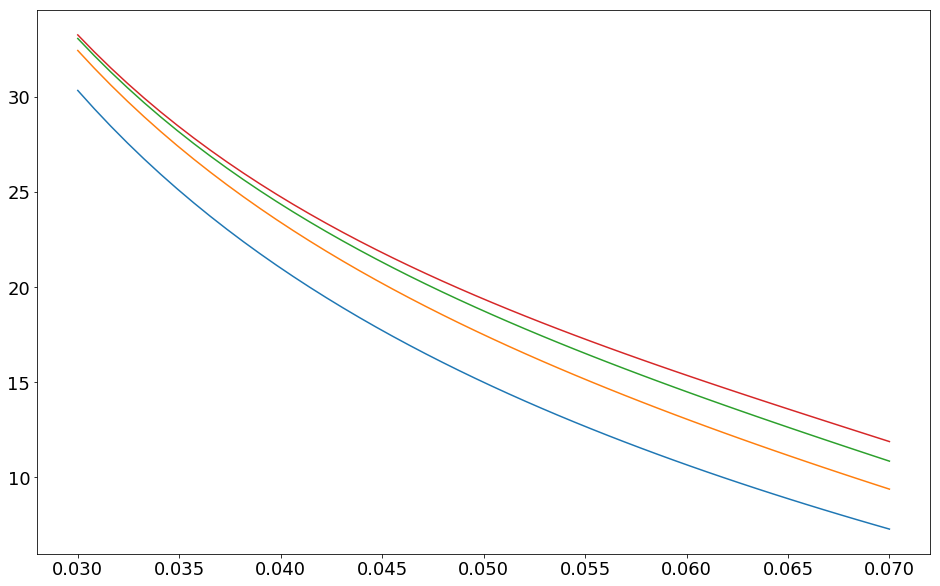

In [299]:

F = UniformCDF([0, 0.1])


for i in range(len(array_sum)):
    x =   np.linspace(0.03, 0.07)
    POD = PriceOverDerivative(i+2, F)
    plt.plot(x, POD(x))
#     print(POD.solve(array_sum[i]))

In [312]:
x = np.linspace(0,10)

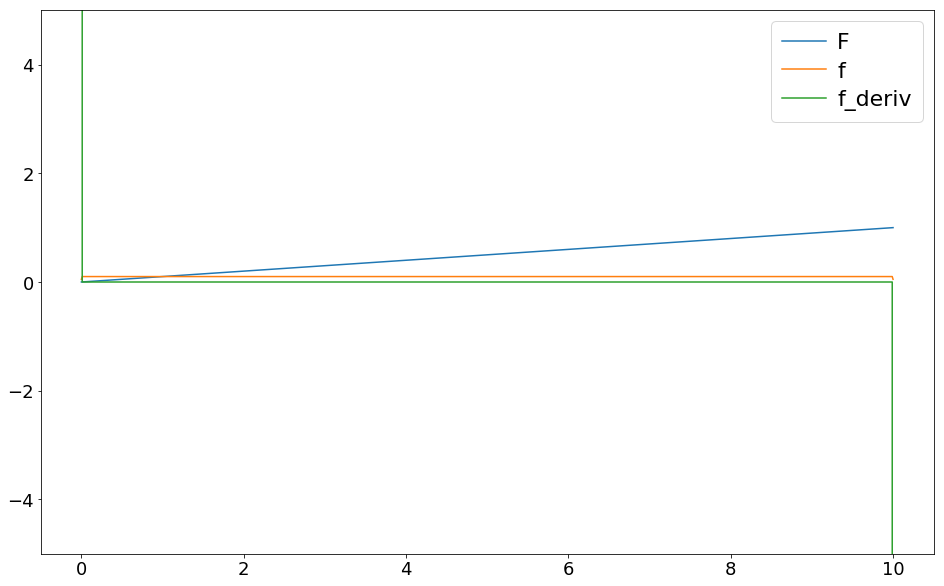

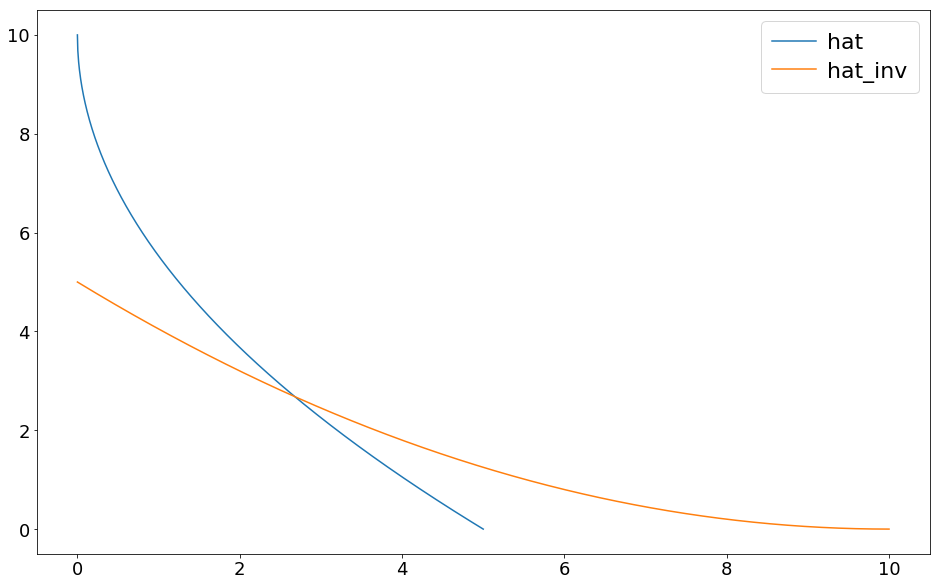

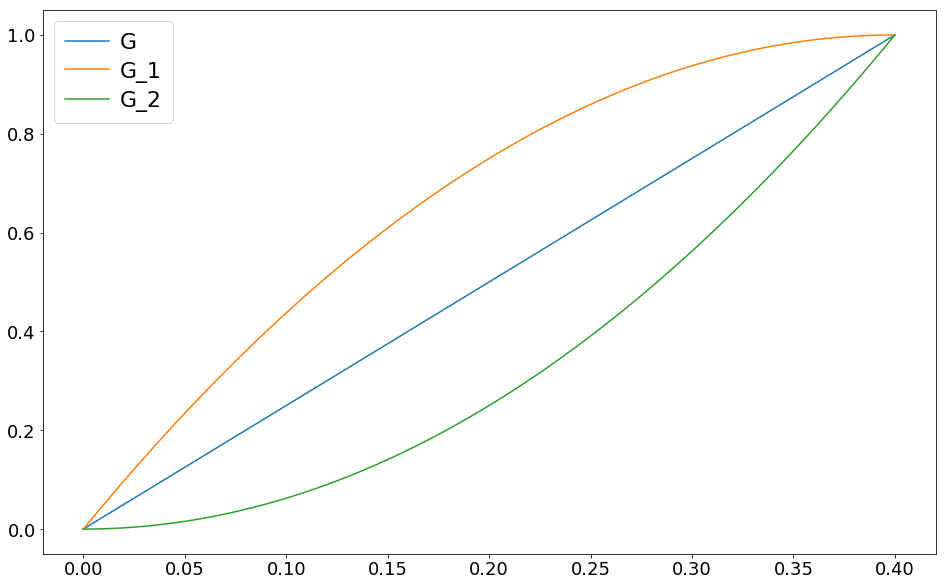

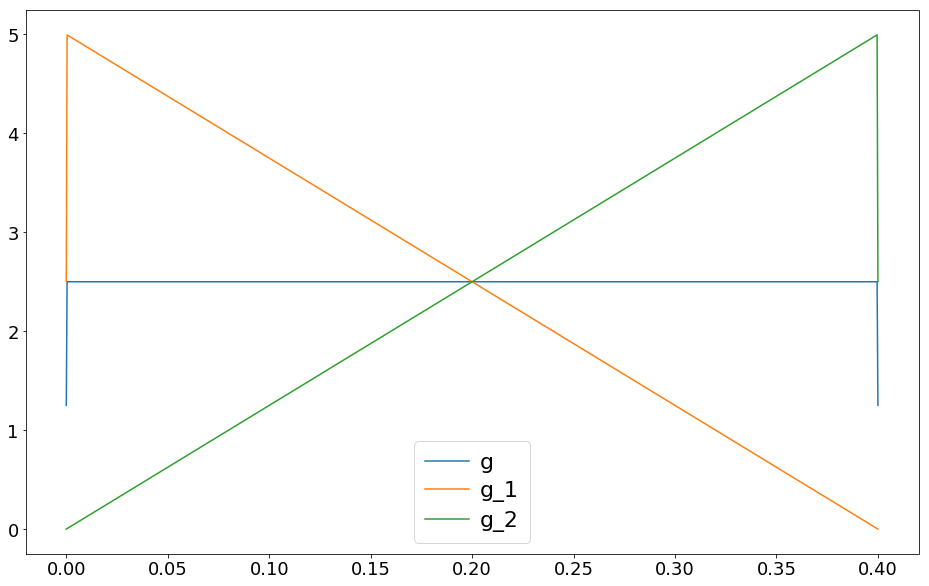

0.17737277981701738

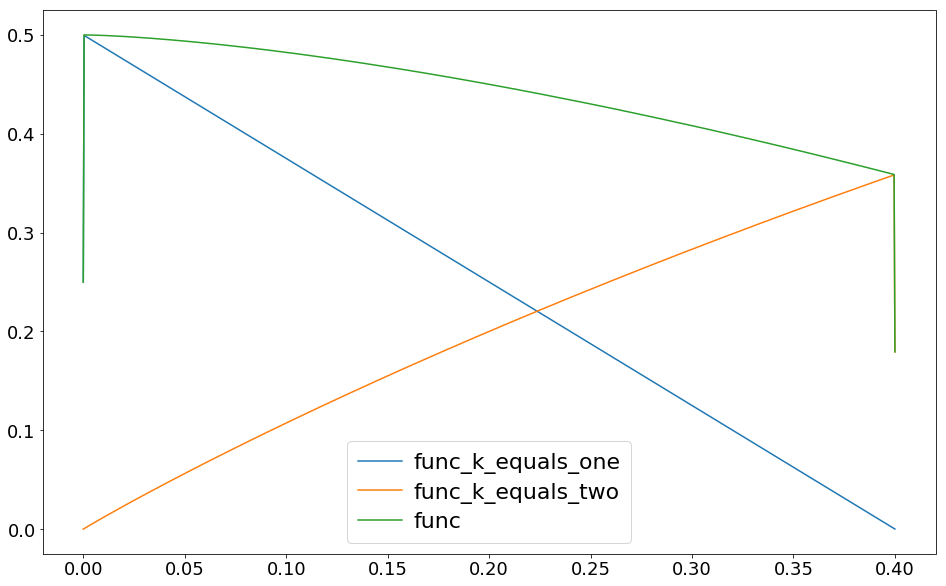

In [387]:
RHS(F, G, full_verbose=True)

In [392]:
PriceOverDerivative(2, F).solve(0.17737277981701738)

4.497465810101438

In [385]:
cur_power = 1
# F = CDF(lambda x : x**cur_power)
F = UniformCDF([0, 10])
G = UniformCDF([0, 0.4])

In [389]:
array = [
    RHS_n_shops(F, G, i) for i in range(2, 4)
]

array_sum = [sum(arr) for arr in array]

for i in range(len(array_sum)):
    POD = PriceOverDerivative(i+2, F)
    print(POD.solve(array_sum[i]))

/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



4.497480115478341
3.942295268437783


/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



uniform pdf called


1.6422293913240633

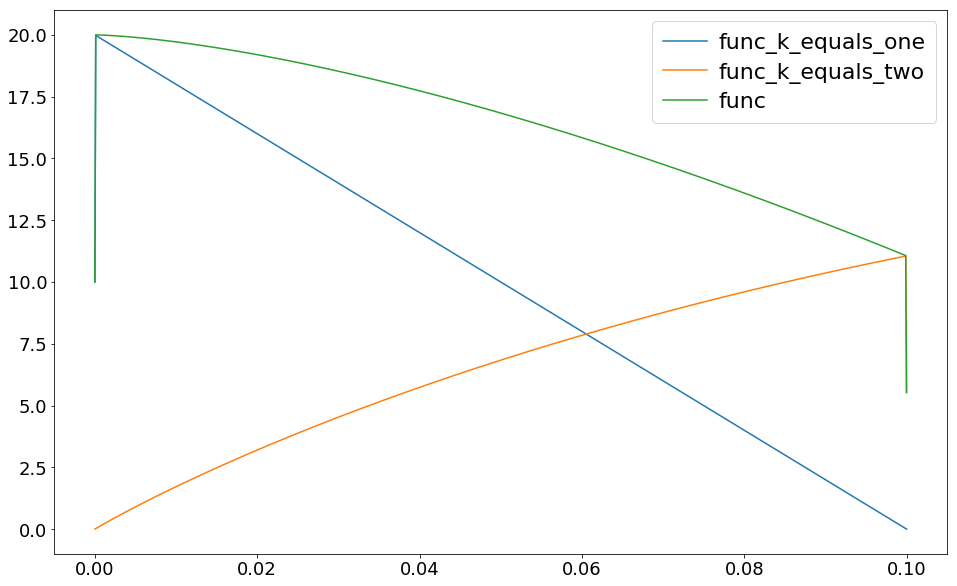

In [67]:
RHS(UniformCDF(), UniformCDF([0, 0.1]))

In [179]:
powers= np.arange(1, 3.1, 0.1)

In [192]:
list_of_RHS = [RHS(CDF(lambda x: x**(t)), UniformCDF([0.1, 0.11]), verbose=False) for t in powers]
list_of_RHS = np.array(list_of_RHS)

In [193]:
list_of_RHS

array([1.53814834, 1.58137157, 1.62198046, 1.66001861, 1.69557932,
       1.72877897, 1.75974194, 1.78859313, 1.81545436, 1.84044144,
       1.86366395, 1.88522451, 1.90521981, 1.92373869, 1.94086472,
       1.95667609, 1.97124512, 1.98463913, 1.99692212, 2.00815209,
       2.01838443])

In [194]:
equilibrium_prices = [
    PriceOverDerivative(2, F=CDF(lambda x: x**(powers[i]))).solve(list_of_RHS[i])
    for i in range(len(powers))
]

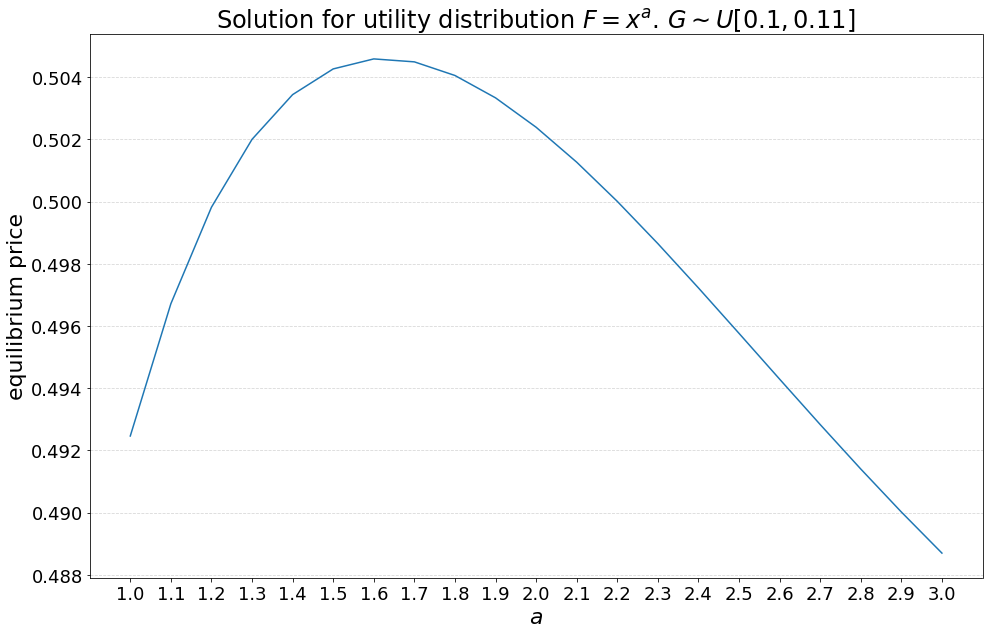

In [195]:
plt.title("Solution for utility distribution $F=x^{a}$. $G \sim U[0.1, 0.11]$")
# plt.plot(powers, list_of_RHS / 5, label="RHS multiplied by 0.2")
plt.plot(powers, equilibrium_prices, label = "equilibrium prices")
plt.ylabel("equilibrium price")
plt.xlabel("$a$")
plt.xticks(powers)
# plt.legend()
plt.grid(alpha=0.5, axis='y', ls='--')
plt.show()


In [76]:
right_end = np.arange(0.7, 2, 0.2)

list_of_RHS2 =  [RHS(UniformCDF([0, t]), UniformCDF([0, 0.1]), verbose=False) for t in right_end]
list_of_RHS2 = np.array(list_of_RHS2)

equilibrium_prices2 = [
    PriceOverDerivative(2, F=UniformCDF([0, right_end[i]])).solve(list_of_RHS2[i])
    for i in range(len(right_end))
]

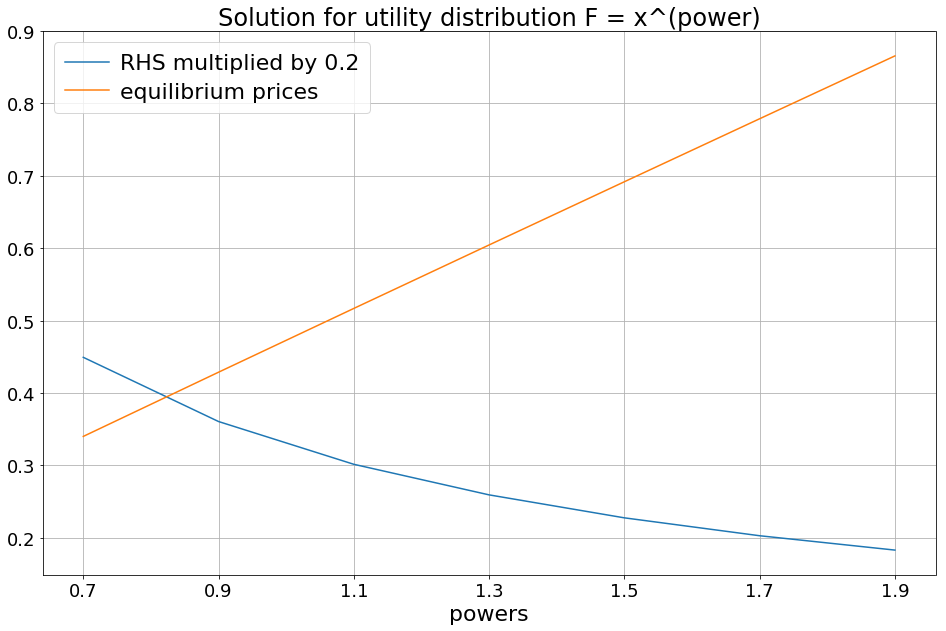

In [87]:
plt.title("Solution for utility distribution F = x^(power)")
plt.plot(right_end, list_of_RHS2 / 5, label="RHS multiplied by 0.2")
plt.plot(right_end, equilibrium_prices2, label = "equilibrium prices")
plt.xlabel("powers")
plt.xticks(right_end[::-1])
plt.legend()
plt.grid()
plt.show()


## HERE NOW



In [143]:
list_of_F = [
    UniformCDF([0, 1.5]),
    CDF(lambda x : 16 / 9 * x**2, [0, 0.75])
#     UniformCDF([0.7, 1.3]),
]

In [144]:
ExpectedValue(CDF(lambda x : 16 / 9 * x**2, [0, 0.75]))

0.5000000018625279

In [145]:
list_of_RHS3 =  [RHS(F, UniformCDF([0, 0.1]), verbose=False) for F in list_of_F]

/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [146]:
hat_inv_0, hat_0 = Get_x_hat_inverse_and_x_hat(list_of_F[0])

In [147]:
hat_inv_1, hat_1 = Get_x_hat_inverse_and_x_hat(list_of_F[1])

In [148]:
hat_0.right_bound

0.7499999999999999

In [149]:
xxx_05 = np.linspace(0, 0.5)

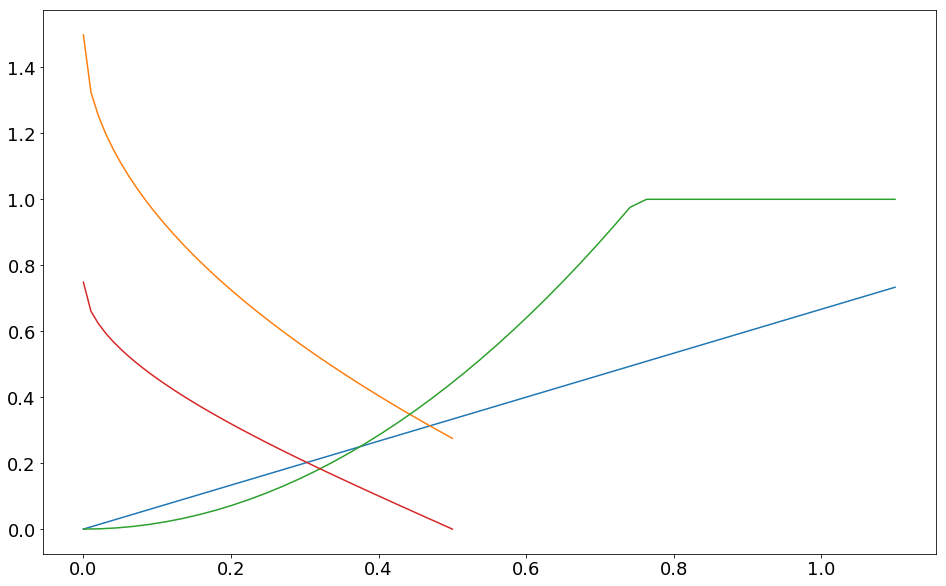

In [150]:
xxx = np.linspace(0, 1.1)

plt.plot(xxx, list_of_F[0](xxx))
plt.plot(xxx_05, hat_0(xxx_05))

plt.plot(xxx, list_of_F[1](xxx))
plt.plot(xxx_05, hat_1(xxx_05))


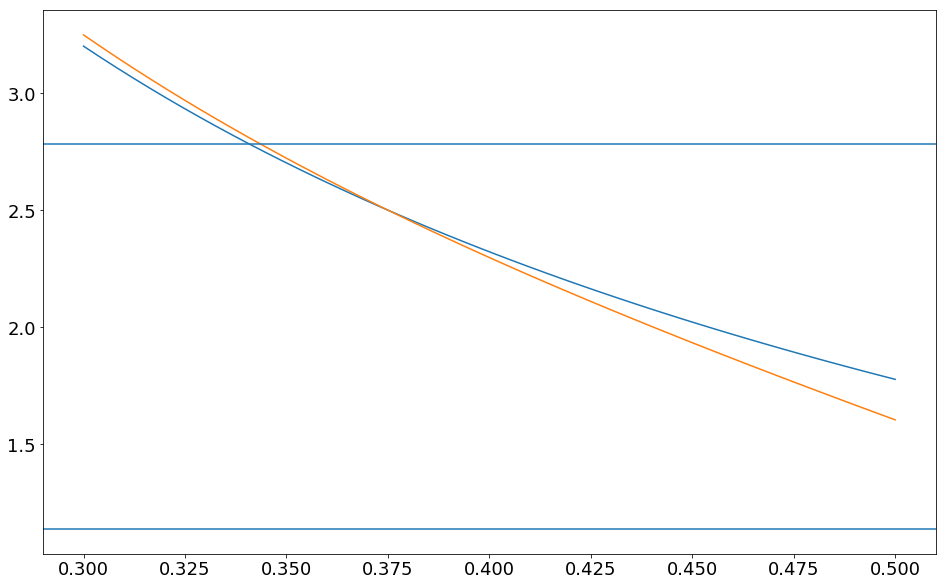

In [151]:
plt.plot(x, PriceOverDerivative(2, list_of_F[0])(x))
plt.plot(x, PriceOverDerivative(2, list_of_F[1])(x))

plt.axhline(list_of_RHS3[0])

plt.axhline(list_of_RHS3[1])

In [152]:

PriceOverDerivative(2, list_of_F[0]).solve(list_of_RHS3[0])

0.6915830402572711

In [153]:
ExpectedValue(list_of_F[1])

0.5000000018625279

In [154]:
PriceOverDerivative(2, list_of_F[1]).solve(list_of_RHS3[1])

0.34344052022488286

In [104]:
equilibrium_prices3 = [
    PriceOverDerivative(2, F).solve(list_of_RHS3[i])
    for i in range(len(right_end))
]

/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [88]:
right_end = np.arange(0.7, 2, 0.2)

list_of_RHS3 =  [RHS(UniformCDF([0, t]), UniformCDF([0, 0.01]), verbose=False) for t in right_end]
list_of_RHS3 = np.array(list_of_RHS3)

equilibrium_prices3 = [
    PriceOverDerivative(2, F=UniformCDF([0, right_end[i]])).solve(list_of_RHS3[i])
    for i in range(len(right_end))
]

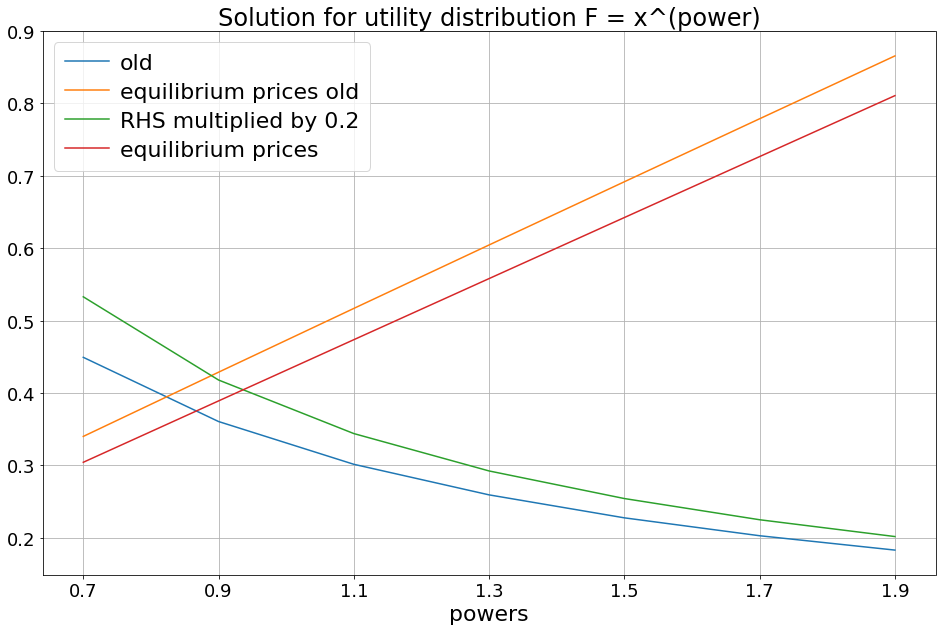

In [91]:
plt.title("Solution for utility distribution F = x^(power)")

plt.plot(right_end, list_of_RHS2 / 5, label="old")
plt.plot(right_end, equilibrium_prices2, label = "equilibrium prices old")


plt.plot(right_end, list_of_RHS3 / 5, label="RHS multiplied by 0.2")
plt.plot(right_end, equilibrium_prices3, label = "equilibrium prices")
plt.xlabel("powers")
plt.xticks(right_end[::-1])
plt.legend()
plt.grid()
plt.show()


In [ ]:
a

In [ ]:
for i in [0,2,4]:
    x = np.linspace(0.45, 0.55, 100)
    POD = PriceOverDerivative(2, F=CDF(lambda x: x**(powers[i])))
    plt.plot(x, POD(x), label=i)
    plt.axhline(y=list_of_RHS[i], c=colors[i], label=i)
    
#     plt.show()
    print(POD.solve(list_of_RHS[i]))
plt.legend()

In [108]:
colors = ['b', 'r', 'orange', 'gold', 'g']

0.47280545003172436
0.5271715693412797
0.5254331870825258


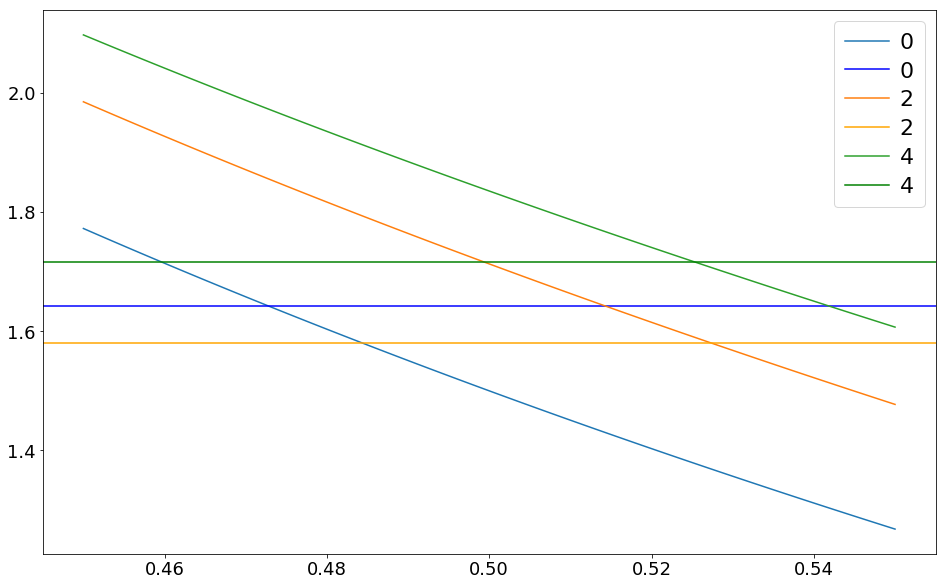

In [109]:
for i in [0,2,4]:
    x = np.linspace(0.45, 0.55, 100)
    POD = PriceOverDerivative(2, F=CDF(lambda x: x**(powers[i])))
    plt.plot(x, POD(x), label=i)
    plt.axhline(y=list_of_RHS[i], c=colors[i], label=i)
    
#     plt.show()
    print(POD.solve(list_of_RHS[i]))
plt.legend()

In [179]:
x = np.linspace(0.4, 0.6)

[]

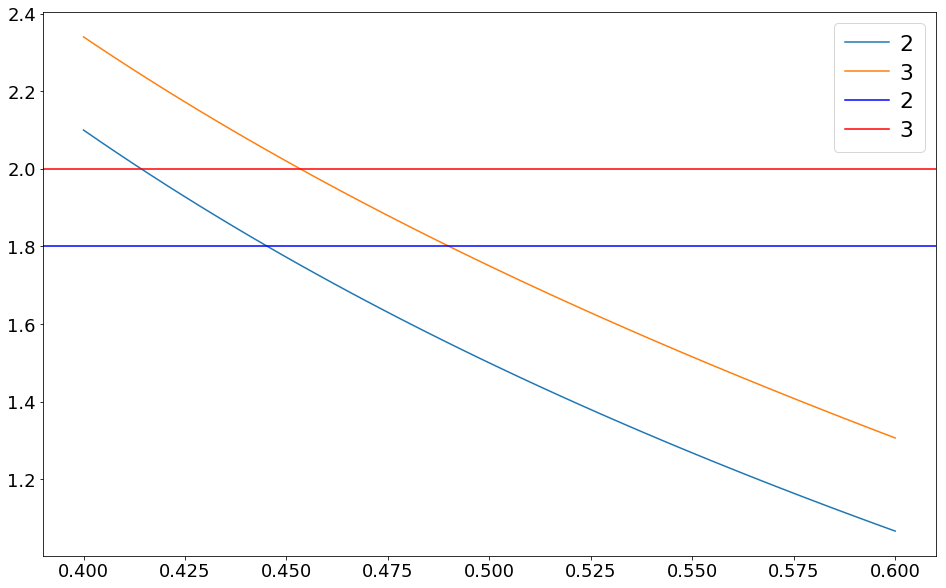

In [185]:
for i in range(2, 4):
    POD = PriceOverDerivative(i, F=CDF(lambda x: x))
    plt.plot(x, POD(x), label=i)
    
plt.axhline(y=1.8, c='b', label=2)
plt.axhline(y=2, c='r', label=3)


plt.legend()
plt.plot()

In [240]:
F = CDF(lambda x : 2**x - 1)

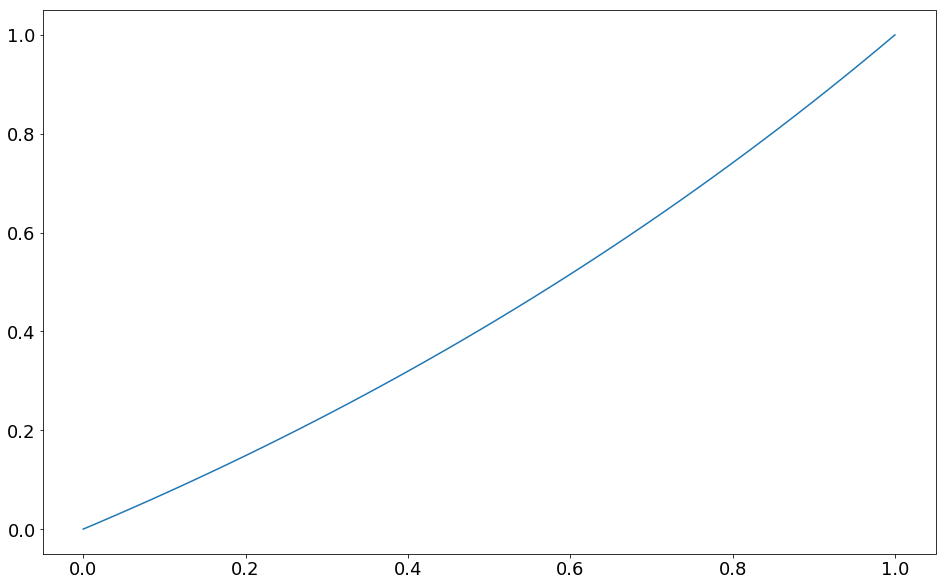

In [243]:
x = np.linspace(0, 1)
plt.plot(x, F(x))

In [244]:
F(ExpectedValue(F))

array(0.47151777)

## Moraga

In [520]:
def Moraga_3(F, G, p_eq, p, c, n=3):
    
    
    hat_inv, hat = Get_x_hat_inverse_and_x_hat(F)
    
    f = CDF_to_PDF(F)
    g = CDF_to_PDF(G)
    f_deriv = Derivative(f)    
    
    def integrand(t):
        return f(t - p_eq + p) * F(t)**(n-1)
    
    def func_k_equals_one(x):
        return (1 - F(x)**n) / (1 - F(x)) * (1 -  F(x - p_eq + p)) \
                + n * integrate.quad(integrand, p_eq, x)[0]

#     def func_k_equals_one(x):
#         return 3 * integrate.quad(integrand, p_eq, x)[0]
        

    return np.array([func_k_equals_one(c_) for c_ in c])

In [551]:
def Moraga_3_second_derivative(F, G, p_eq, p, c, n=3):
    hat_inv, hat = Get_x_hat_inverse_and_x_hat(F)
    
    f = CDF_to_PDF(F)
    g = CDF_to_PDF(G)
    f_deriv = Derivative(f)    
        
    def func_k_equals_one(x):
        return 2*f(x) \
              * ((1 - F(x -p_eq + p)) * f(x) - (1 - F(x)) * f(x - p_eq +p))

#     def func_k_equals_one(x):
#         return 3 * integrate.quad(integrand, p_eq, x)[0]
        

    return np.array([func_k_equals_one(c_) for c_ in c])

In [490]:
# p_eq = 0.4
# p = 0.35

# def integrand(t):
#     return f(t - p_eq + p) * F(t)**2

# x = np.linspace(0, 0.1)

# plt.plot(x, integrand(x))

In [521]:
F = UniformCDF()
G = UniformCDF([0, 0.1])
number_of_points = 50
c = np.arange(G.left_bound, G.right_bound + EPS, (G.right_bound - G.left_bound) / number_of_points)
    

In [626]:
hat_inv, hat = Get_x_hat_inverse_and_x_hat(F)

In [627]:
hat_inv(0)

array(0.5)

In [629]:
hat_inv(0.1)

array(0.40500005)

In [536]:
Moraga_3(F=F, G=G, p_eq = 0.4, p = 0.3, c=c, n=10)

array([0.99989514, 1.00189915, 1.00391121, 1.00593136, 1.00795966,
       1.00999615, 1.01204089, 1.01409393, 1.01615531, 1.01822508,
       1.02030331, 1.02239003, 1.02448531, 1.02658919, 1.02870173,
       1.03082298, 1.03295299, 1.03509183, 1.03723954, 1.03939618,
       1.04156181, 1.04373648, 1.04592025, 1.04811317, 1.05031531,
       1.05252672, 1.05474746, 1.05697759, 1.05921718, 1.06146627,
       1.06372493, 1.06599322, 1.06827121, 1.07055895, 1.07285652,
       1.07516396, 1.07748135, 1.07980875, 1.08214622, 1.08449384,
       1.08685166, 1.08921976, 1.0915982 , 1.09398705, 1.09638637,
       1.09879624, 1.10121673, 1.1036479 , 1.10608983, 1.10854259,
       1.11100625])

In [ ]:
number_of_points = 50
c = np.arange(hat_inv(G.right_bound) + EPS, hat_inv(G.left_bound), -(hat_inv(G.right_bound) - hat_inv(G.left_bound)) / number_of_points)


In [633]:
c

array([0.40500005, 0.40595005, 0.40690005, 0.40785004, 0.40880004,
       0.40975004, 0.41070004, 0.41165004, 0.41260004, 0.41355004,
       0.41450004, 0.41545004, 0.41640004, 0.41735004, 0.41830004,
       0.41925004, 0.42020004, 0.42115004, 0.42210004, 0.42305004,
       0.42400004, 0.42495004, 0.42590004, 0.42685004, 0.42780004,
       0.42875003, 0.42970003, 0.43065003, 0.43160003, 0.43255003,
       0.43350003, 0.43445003, 0.43540003, 0.43635003, 0.43730003,
       0.43825003, 0.43920003, 0.44015003, 0.44110003, 0.44205003,
       0.44300003, 0.44395003, 0.44490003, 0.44585003, 0.44680003,
       0.44775003, 0.44870002, 0.44965002, 0.45060002, 0.45155002,
       0.45250002, 0.45345002, 0.45440002, 0.45535002, 0.45630002,
       0.45725002, 0.45820002, 0.45915002, 0.46010002, 0.46105002,
       0.46200002, 0.46295002, 0.46390002, 0.46485002, 0.46580002,
       0.46675002, 0.46770002, 0.46865002, 0.46960001, 0.47055001,
       0.47150001, 0.47245001, 0.47340001, 0.47435001, 0.47530

In [634]:
arr = Moraga_3(F=F, G=G, p_eq = 0.4, p = 0.45, c=c, n=3)

arr_numeric_derivative = (arr[2:] - 2* arr[1:-1] + arr[:-2]) / (c[1] - c[0])**2

arr_deriv = Moraga_3_second_derivative(F=F, G=G, p_eq = 0.4, p = 0.45, c=c, n=3)

In [635]:
arr_numeric_derivative

array([-0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.09999889, -0.09999794, -0.09999769, -0.10000527,
       -0.09999235, -0.10000749, -0.0999902 , -0.1000096 , -0.1       ,
       -0.1       , -0.09998769, -0.10001207, -0.1       , -0.1       ,
       -0.1       , -0.09998499, -0.10001473, -0.09999999, -0.09999999,
       -0.09999999, -0.09999999, -0.09998219, -0.1000175 , -0.09

In [636]:
arr_deriv

array([-0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.10000001, -0.10000001,
       -0.10000001, -0.10000001, -0.10000001, -0.10000001, -0.10000001,
       -0.10000001, -0.10000001, -0.10000001, -0.10000001, -0.10000001,
       -0.10000001, -0.10000001, -0.10000001, -0.10000001, -0.10000001,
       -0.10000001, -0.10000001, -0.10000001, -0.10000001, -0.10

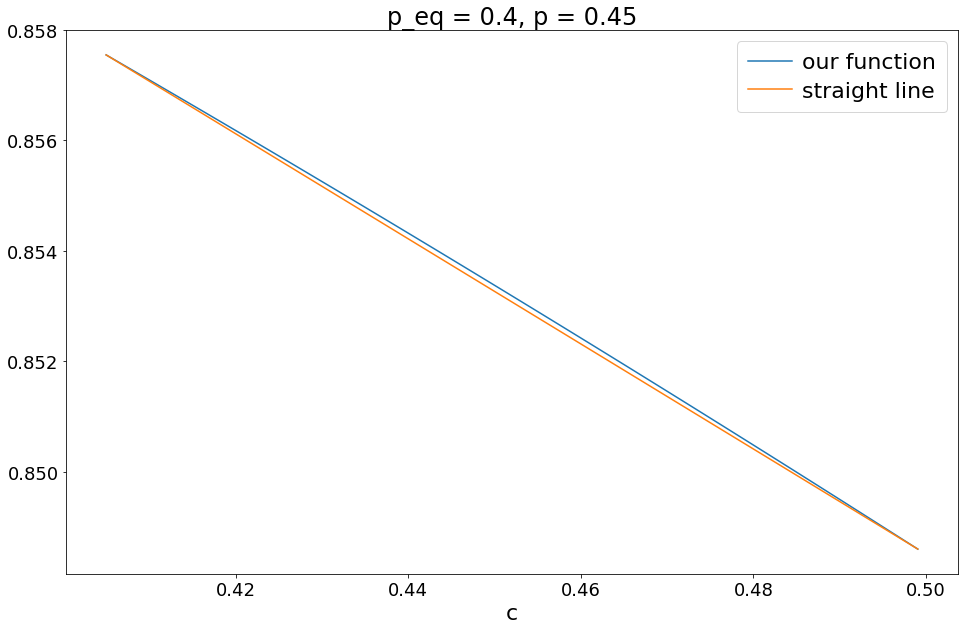

In [638]:
plt.title("p_eq = 0.4, p = 0.45")
plt.plot(c, arr, label='our function')
plt.plot([c[0], c[-1]], [arr[0], arr[-1]], label='straight line')
plt.xlabel('c')
plt.legend()

In [639]:
arr2 = Moraga_3(F=F, G=G, p_eq = 0.4, p = 0.2, c=c, n=3)

arr_numeric_derivative2 = (arr2[2:] - 2* arr2[1:-1] + arr2[:-2]) / (c[1] - c[0])**2

arr_deriv2 = Moraga_3_second_derivative(F=F, G=G, p_eq = 0.4, p = 0.2, c=c, n=3)

In [640]:
arr_numeric_derivative2

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [641]:
arr_deriv2

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [642]:
k=101

In [645]:
c

array([0.40500005, 0.40595005, 0.40690005, 0.40785004, 0.40880004,
       0.40975004, 0.41070004, 0.41165004, 0.41260004, 0.41355004,
       0.41450004, 0.41545004, 0.41640004, 0.41735004, 0.41830004,
       0.41925004, 0.42020004, 0.42115004, 0.42210004, 0.42305004,
       0.42400004, 0.42495004, 0.42590004, 0.42685004, 0.42780004,
       0.42875003, 0.42970003, 0.43065003, 0.43160003, 0.43255003,
       0.43350003, 0.43445003, 0.43540003, 0.43635003, 0.43730003,
       0.43825003, 0.43920003, 0.44015003, 0.44110003, 0.44205003,
       0.44300003, 0.44395003, 0.44490003, 0.44585003, 0.44680003,
       0.44775003, 0.44870002, 0.44965002, 0.45060002, 0.45155002,
       0.45250002, 0.45345002, 0.45440002, 0.45535002, 0.45630002,
       0.45725002, 0.45820002, 0.45915002, 0.46010002, 0.46105002,
       0.46200002, 0.46295002, 0.46390002, 0.46485002, 0.46580002,
       0.46675002, 0.46770002, 0.46865002, 0.46960001, 0.47055001,
       0.47150001, 0.47245001, 0.47340001, 0.47435001, 0.47530

In [ ]:
plt.title("p_eq = 0.4, p = 0.45")
plt.plot(c, arr, label='our function')
plt.plot([0, 0.1], [arr[0], arr[-1]], label='straight line')
plt.xlabel('c')
plt.legend()

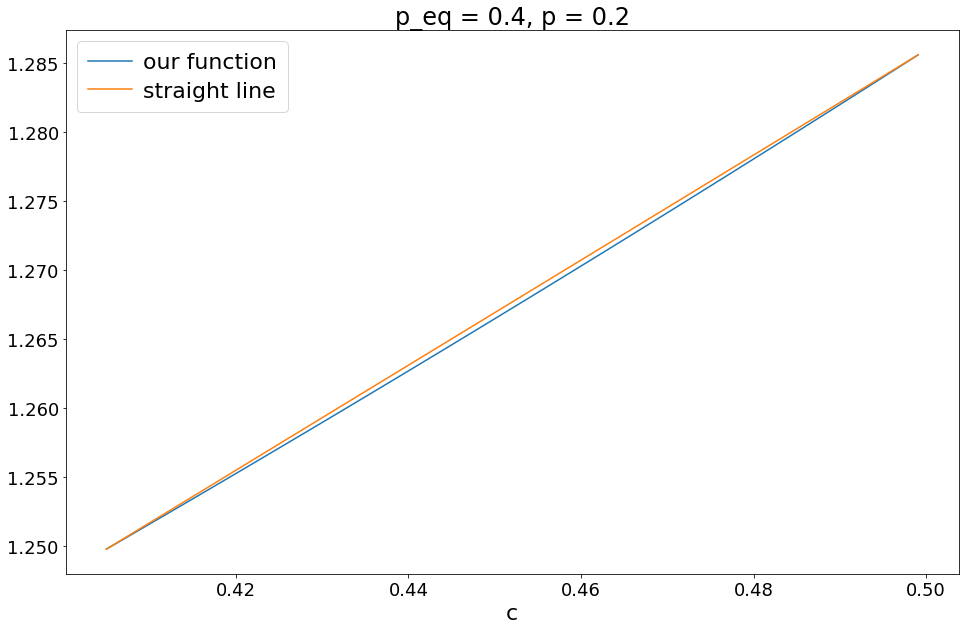

In [644]:
plt.title("p_eq = 0.4, p = 0.2")
plt.plot(c[:k], arr2[:k], label='our function')
plt.plot([c[0], c[-1]], [arr2[0], arr2[-1]], label='straight line')
plt.xlabel('c')
plt.legend()

In [691]:
number_of_points = 50
# c = np.arange(hat_inv(G.right_bound) + EPS, hat_inv(G.left_bound), -(hat_inv(G.right_bound) - hat_inv(G.left_bound)) / number_of_points)
c = np.arange(G.right_bound + EPS, G.left_bound, -(G.right_bound - G.left_bound) / number_of_points)


In [692]:
c

array([1.00000001e-01, 9.80000010e-02, 9.60000010e-02, 9.40000010e-02,
       9.20000010e-02, 9.00000010e-02, 8.80000010e-02, 8.60000010e-02,
       8.40000010e-02, 8.20000010e-02, 8.00000010e-02, 7.80000010e-02,
       7.60000010e-02, 7.40000010e-02, 7.20000010e-02, 7.00000010e-02,
       6.80000010e-02, 6.60000010e-02, 6.40000010e-02, 6.20000010e-02,
       6.00000010e-02, 5.80000010e-02, 5.60000010e-02, 5.40000010e-02,
       5.20000010e-02, 5.00000010e-02, 4.80000010e-02, 4.60000010e-02,
       4.40000010e-02, 4.20000010e-02, 4.00000010e-02, 3.80000010e-02,
       3.60000010e-02, 3.40000010e-02, 3.20000010e-02, 3.00000010e-02,
       2.80000010e-02, 2.60000010e-02, 2.40000010e-02, 2.20000010e-02,
       2.00000010e-02, 1.80000010e-02, 1.60000010e-02, 1.40000010e-02,
       1.20000010e-02, 1.00000010e-02, 8.00000100e-03, 6.00000100e-03,
       4.00000100e-03, 2.00000100e-03, 9.99999916e-10])

In [695]:
c = hat_inv(c)

In [ ]:
c = np.arange(hat_inv(G.right_bound) + EPS, hat_inv(G.left_bound), -(hat_inv(G.right_bound) - hat_inv(G.left_bound)) / number_of_points)


In [696]:
matrix = np.array([
    Moraga_3(F=F, G=G, p_eq = 0.4, p = p_change, c=c, n=3)
    for p_change in np.arange(0.3, 0.51, 0.04)
])

In [697]:
matrix

array([[1.09290251, 1.09322899, 1.09355686, 1.0938861 , 1.09421673,
        1.09454875, 1.09488216, 1.09521697, 1.09555318, 1.0958908 ,
        1.09622983, 1.09657028, 1.09691214, 1.09725543, 1.09760015,
        1.09794631, 1.0982939 , 1.09864293, 1.09899341, 1.09934534,
        1.09969873, 1.10005358, 1.10040989, 1.10076767, 1.10112693,
        1.10148766, 1.10184988, 1.10221358, 1.10257878, 1.10294547,
        1.10331367, 1.10368337, 1.10405458, 1.10442731, 1.10480155,
        1.10517732, 1.10555462, 1.10593346, 1.10631383, 1.10669574,
        1.10707921, 1.10746422, 1.10785079, 1.10823893, 1.10862863,
        1.1090199 , 1.10941275, 1.10980718, 1.1102028 , 1.1106007 ,
        1.111     ],
       [1.0301415 , 1.0303374 , 1.03053411, 1.03073166, 1.03093004,
        1.03112925, 1.0313293 , 1.03153018, 1.03173191, 1.03193448,
        1.0321379 , 1.03234217, 1.03254729, 1.03275326, 1.03296009,
        1.03316778, 1.03337634, 1.03358576, 1.03379605, 1.03400721,
        1.03421924, 1.03443

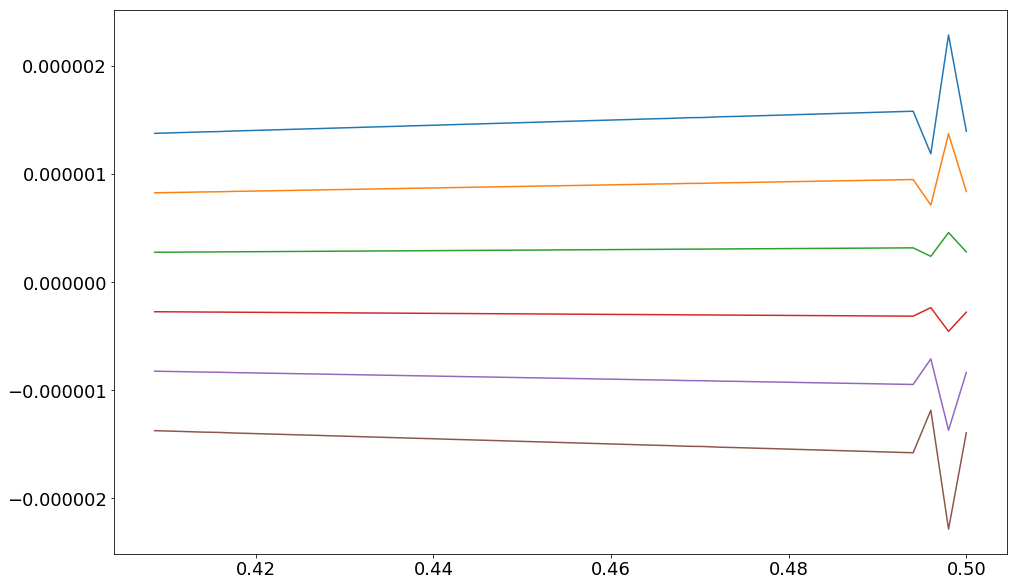

In [698]:
for i in range(len(matrix)):
    plt.plot(c[2:], matrix[i][2:] - 2* matrix[i][1:-1] + matrix[i][:-2])

In [702]:
pchange = np.arange(0.3, 0.51, 0.04)

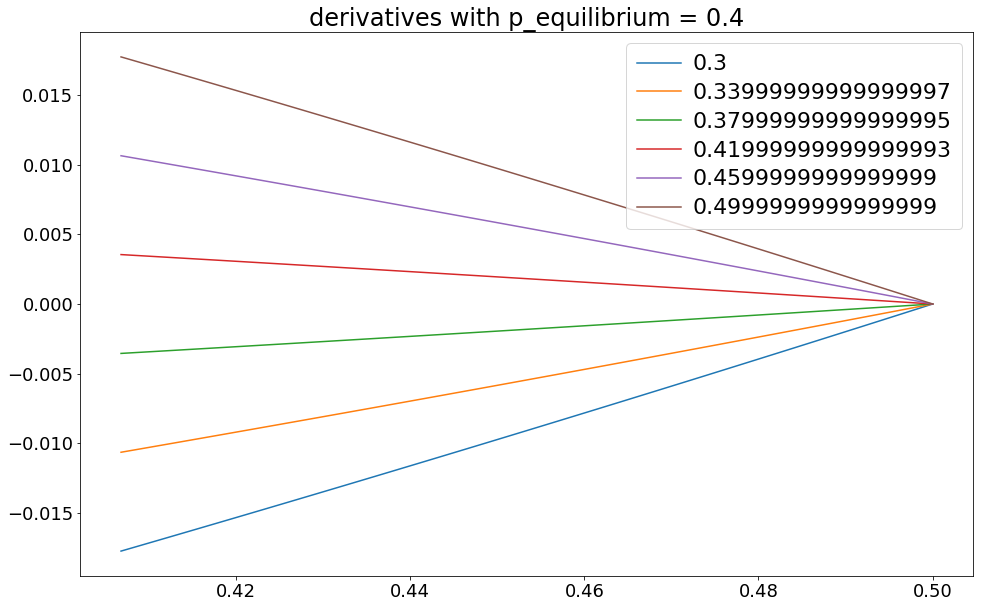

In [704]:
plt.title("derivatives with p_equilibrium = " + str(p_eq))

for i in range(len(matrix)):
    plt.plot(c[1:], matrix[i][1:] - matrix[i][-1:], label=pchange[i])
    
plt.legend()

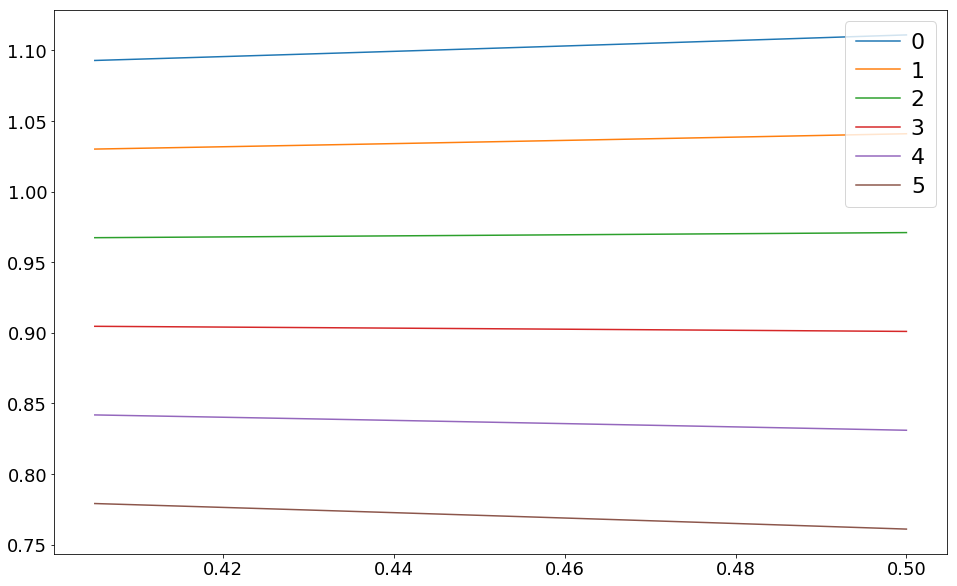

In [700]:
for i in range(len(matrix)):
    plt.plot(c, matrix[i], label=i)
    
plt.legend()

In [701]:
g = CDF_to_PDF(G)

In [689]:
def density_for_moraga(x):
    x = np.asarray(x)
    hat_inverse_deriv = Derivative(hat_inv)
    
#     vv = np.linspace(0.4, 0.5)
#     plt.plot(vv, hat_inverse_deriv(vv))
    
    return g(hat(x) - EPS) * np.abs(hat_inverse_deriv(x))

In [690]:
c

array([0.40500005, 0.40690005, 0.40880004, 0.41070004, 0.41260004,
       0.41450004, 0.41640004, 0.41830004, 0.42020004, 0.42210004,
       0.42400004, 0.42590004, 0.42780004, 0.42970003, 0.43160003,
       0.43350003, 0.43540003, 0.43730003, 0.43920003, 0.44110003,
       0.44300003, 0.44490003, 0.44680003, 0.44870002, 0.45060002,
       0.45250002, 0.45440002, 0.45630002, 0.45820002, 0.46010002,
       0.46200002, 0.46390002, 0.46580002, 0.46770002, 0.46960001,
       0.47150001, 0.47340001, 0.47530001, 0.47720001, 0.47910001,
       0.48100001, 0.48290001, 0.48480001, 0.48670001, 0.48860001,
       0.4905    , 0.4924    , 0.4943    , 0.4962    , 0.4981    ])

In [676]:
xxx = np.linspace(0.1, 0.9)

In [677]:
hat_inverse_deriv = Derivative(hat_inv)

In [678]:
hat_inverse_deriv.right_bound

1

In [684]:
hat(0)

array(0.99799778)

In [680]:
xxx = np.linspace(0.4, 0.5)

In [688]:
hat(c)

array([0.1       , 0.0978914 , 0.0957877 , 0.09368888, 0.0915949 ,
       0.08950572, 0.08742131, 0.08534165, 0.08326671, 0.08119644,
       0.07913083, 0.07706985, 0.07501351, 0.07296172, 0.07091446,
       0.0688717 , 0.06683341, 0.06479956, 0.06277013, 0.06074506,
       0.05872436, 0.05670798, 0.05469591, 0.05268811, 0.05068455,
       0.04868522, 0.04669008, 0.0446991 , 0.04271226, 0.04072954,
       0.0387509 , 0.03677633, 0.03480579, 0.03283927, 0.03087674,
       0.02891817, 0.02696353, 0.02501281, 0.02306603, 0.02112313,
       0.01918407, 0.01724884, 0.01531741, 0.01338975, 0.01146585,
       0.00954568, 0.00762922, 0.00571644, 0.00380549, 0.00190139])

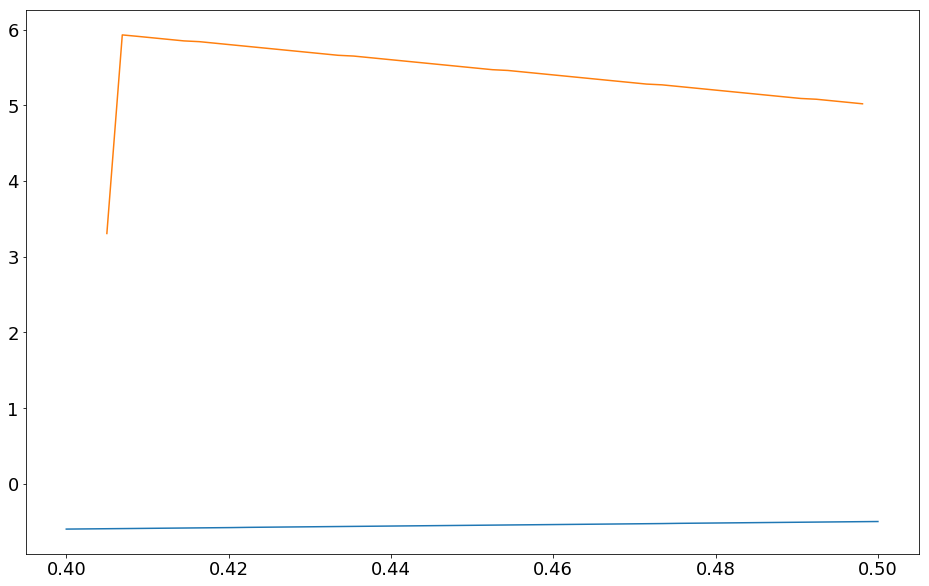

In [685]:
plt.plot(c, density_for_moraga(c))

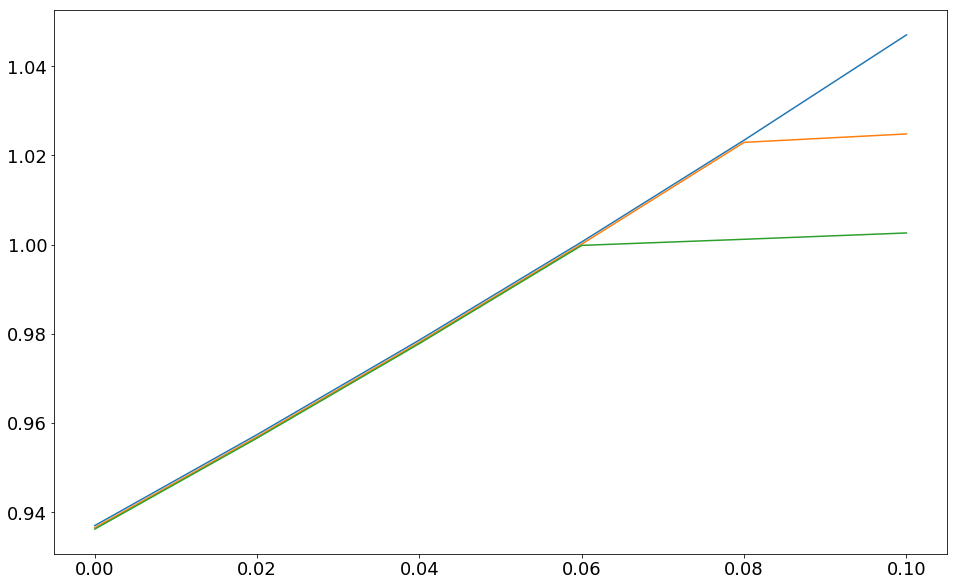

In [500]:
plt.plot(c, matrix[0])
plt.plot(c, matrix[1])
plt.plot(c, matrix[2])

(-1, 3)

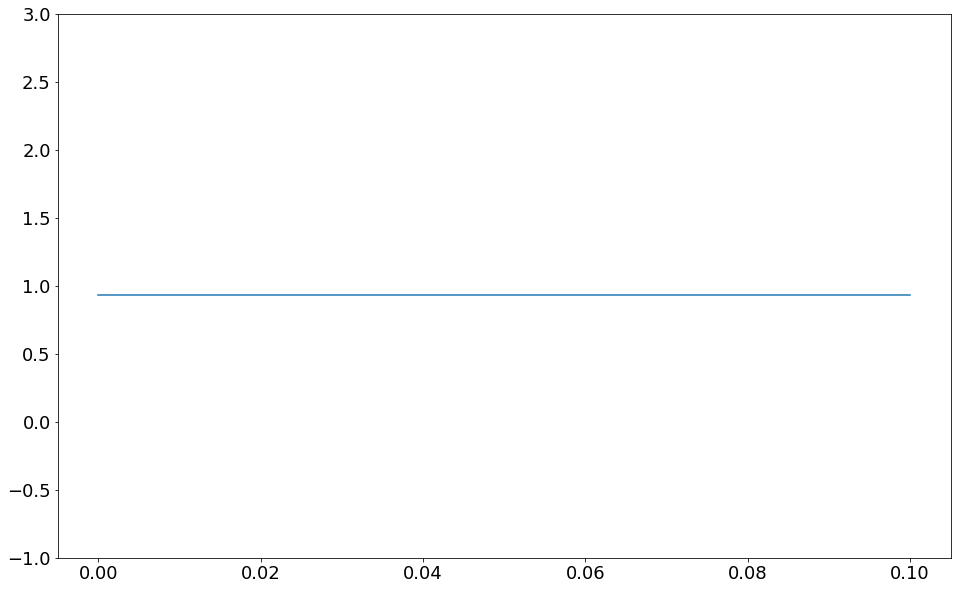

In [473]:
plt.plot(c, f_c)
plt.ylim(-1, 3)

## Trash

In [100]:
import pandas as pd

In [101]:

z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

data = [
    go.Surface(
        z=matrix
    )
]
layout = go.Layout(
    title='Mt Bruno Elevation',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

NameError: name 'go' is not defined

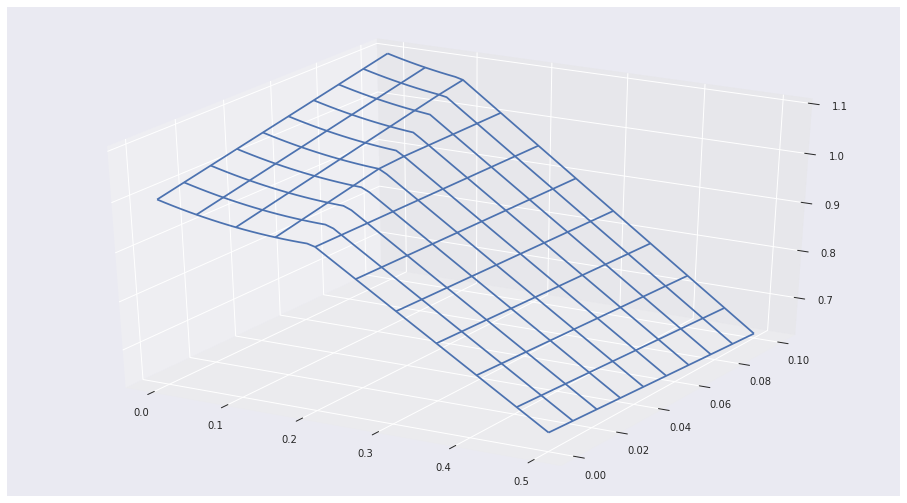